# Low-Dimensional Representation Using Autoencoder

## Getting the Data

In [169]:
import warnings
warnings.filterwarnings("ignore")
import sys
from herdingspikes.hs2 import HSDetection
from herdingspikes.probe import HierlmannVisapyEmulationProbe
import matplotlib.pyplot as plt
import h5py
import numpy as np

np.random.seed(0)

In [170]:
# raw data location
data_path = 'visapy_data.npy'

In [171]:
# detection parameters
to_localize = True
cutout_start = 14
cutout_end = 36
threshold = 24
file_directory = 'results/'
file_name = 'ProcessedSpikes_visapy'

In [172]:
Probe = HierlmannVisapyEmulationProbe('visapy_data.npy')
H = HSDetection(Probe, to_localize, cutout_start, cutout_end, threshold,
                maa=0, maxsl=12, minsl=3, ahpthr=0, out_file_name=file_name, 
                file_directory_name=file_directory, save_all=True)

File size: 122400102
Number of channels: 102


## Detecting Spikes

In [173]:
H.DetectFromRaw()

# Sampling rate: 32000
# Localization On
# Not Masking any Channels
# Writing out extended detection info
# Number of recorded channels: 102
# Analysing frames: 1200001, Seconds:37.50003125
# Frames before spike in cutout: 32
# Frames after spike in cutout: 70
# tcuts: 44 59
# tInc: 50000
# Analysing 50000 frames; from -44 to 50059
# Analysing 50000 frames; from 49956 to 100059
# Analysing 50000 frames; from 99956 to 150059
# Analysing 50000 frames; from 149956 to 200059
# Analysing 50000 frames; from 199956 to 250059
# Analysing 50000 frames; from 249956 to 300059
# Analysing 50000 frames; from 299956 to 350059
# Analysing 50000 frames; from 349956 to 400059
# Analysing 50000 frames; from 399956 to 450059
# Analysing 50000 frames; from 449956 to 500059
# Analysing 50000 frames; from 499956 to 550059
# Analysing 50000 frames; from 549956 to 600059
# Analysing 50000 frames; from 599956 to 650059
# Analysing 50000 frames; from 649956 to 700059
# Analysing 50000 frames; from 699956 to 750

In [174]:
H.LoadDetected()

Detected and read 19341 spikes.


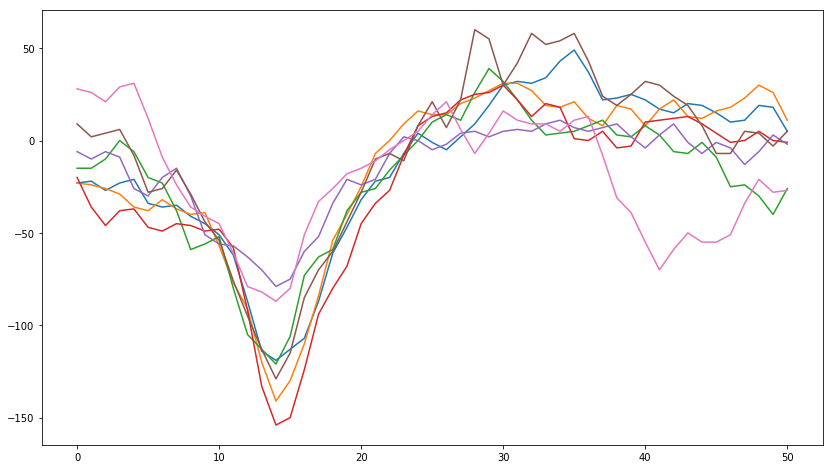

In [175]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.figure(figsize=(14,8))
for i in [11, 290, 3490, 1098, 2707, 9, 871]:
    plt.plot(H.spikes['Shape'][i])
plt.show()
    

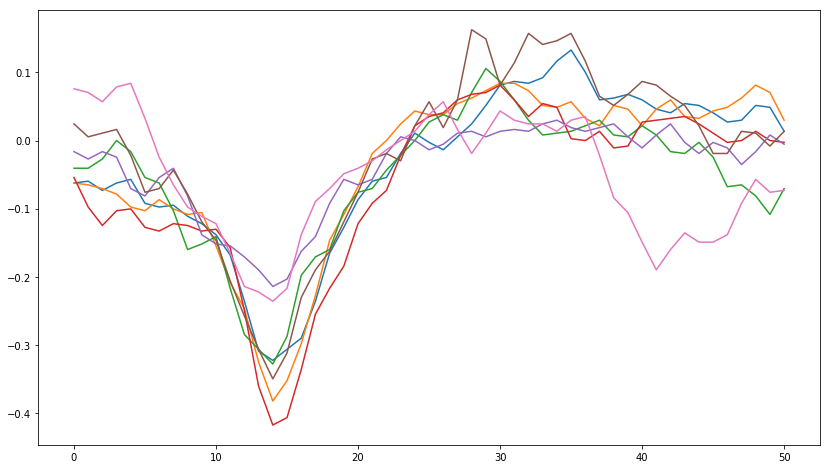

In [203]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.figure(figsize=(14,8))
for i in [11, 290, 3490, 1098, 2707, 9, 871]:
    plt.plot(electrode_data[i, :])
plt.show()
    

In [176]:
length = H.spikes['Shape'][0].shape[0]
total_sigs = H.spikes['Shape'].shape[0]

electrode_data = np.zeros([total_sigs, length])
list_of_sigs = np.random.choice(total_sigs, total_sigs, replace=False)

for i in list_of_sigs:
    electrode_data[i, :] = H.spikes['Shape'][i]
print(electrode_data.shape)

(19341, 51)


In [9]:
# from sklearn.decomposition import PCA

# pca = PCA(n_components=12)
# pca.fit(electrode_data)
# e_data_pca = pca.transform(electrode_data_train)
# e_data_proj = pca.inverse_transform(e_data_pca)

In [10]:
# plt.figure(figsize=(14,4))

# n = [3490, 1098, 2377, 9, 871]

# for i in n:
#     plt.subplot(121)
#     plt.plot(electrode_data_test[i, :])
#     plt.title('Original')
#     plt.xlabel('Time')
#     plt.ylabel('Amplitude')
#     plt.subplot(122)
#     plt.plot(e_data_proj[i, :])
#     plt.title('PCA reconstruction')
#     plt.xlabel('Time')
#     plt.ylabel('Amplitude')
# plt.show()

## Scaling data between 0 and 1

In [178]:
electrode_data_temp = electrode_data[:, :]

In [179]:
max_val = np.amax(electrode_data)
min_val = np.amin(electrode_data)
span = max_val - min_val
electrode_data = electrode_data/span

In [180]:
print(electrode_data)

[[-0.01897019 -0.00542005  0.01084011 ...  0.01897019  0.01897019
   0.02439024]
 [ 0.09485095  0.08943089  0.0704607  ...  0.         -0.01897019
  -0.02710027]
 [ 0.04065041  0.04336043  0.02168022 ... -0.0298103  -0.00271003
   0.00271003]
 ...
 [-0.00542005 -0.05149051 -0.06233062 ... -0.01897019 -0.04065041
  -0.08401084]
 [ 0.03252033  0.         -0.00813008 ... -0.02168022 -0.02710027
  -0.01355014]
 [-0.05420054 -0.08672087 -0.07859079 ...  0.02439024  0.
  -0.02439024]]


## Designing the AutoEncoder 

In [181]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils import data
import random

torch.cuda.set_device(0)
torch.manual_seed(0)

In [42]:
class lstm_autoencoder1(nn.Module):
    def __init__(self, input_size, seq_len, embedding_size):
        super(lstm_autoencoder1, self).__init__()
        if input_size%seq_len != 0:
            print('Input size dimensions not divisible by sequence length')
            return None
        self.activation_layer = nn.PReLU()
        self.seq_len = seq_len
        
        first_lin_size = 4*(input_size//self.seq_len)
        
        self.lstm1 = nn.LSTM(input_size=self.seq_len, hidden_size=4, num_layers=1)
        #self.lstm2 = nn.LSTM(input_size=15, hidden_size=28, num_layers=2)
        self.lin1 = nn.Linear(first_lin_size, embedding_size)
        #self.lin2 = nn.Linear(80, embedding_size)
        
        self.lin2 = nn.Linear(embedding_size, 10)
        self.lin3 = nn.Linear(10, first_lin_size)
        self.lin4 = nn.Linear(first_lin_size, input_size)
    
    def forward(self, x, hidden=None):
        x = self.serialise_input(x)
        out, _ = self.lstm1(x, hidden)
        #out, _ = self.lstm2(out, hidden)
        out = self.flatten_input(out)
        out = self.lin1(out)
        #out = self.activation_layer(out)
        enc = self.lin2(out)
        out = self.activation_layer(enc)
        out = self.lin3(enc)
        out = self.activation_layer(out)
        dec = self.lin4(out)
        return enc, dec
    
    def serialise_input(self, data):
        data = data.view(-1, 1, self.seq_len)
        return data
    
    def flatten_input(self, data):
        data = data.view(-1)
        return data

In [201]:
class lstm_autoencoder2(nn.Module):
    def __init__(self, input_size, seq_len, embedding_size):
        super(lstm_autoencoder2, self).__init__()
        if input_size%seq_len != 0:
            print('Input size dimensions not divisible by sequence length')
            return None
        self.activation_layer = nn.PReLU()
        self.seq_len = seq_len
        
        first_lin_size = 51*(input_size//self.seq_len)
        #first_lin_size = 28
        #embedding_size = 4
        
        self.lstm1 = nn.LSTM(input_size=self.seq_len, hidden_size=51, num_layers=4)
        #self.lstm2 = nn.LSTM(input_size=15, hidden_size=28, num_layers=2)
        self.lin1 = nn.Linear(first_lin_size, embedding_size)
        #self.lin2 = nn.Linear(80, embedding_size)
        
        self.lin2 = nn.Linear(embedding_size, first_lin_size)
        self.lstm2 = nn.LSTM(input_size=51, hidden_size=self.seq_len, num_layers=4)
        
        self.lin3 = nn.Linear(51, 51)
    
    def forward(self, x, hidden=None):
        x = self.serialise_input(x)
        out, _ = self.lstm1(x, hidden)
        #out = out[-1]
        #out, _ = self.lstm2(out, hidden)
        out = self.flatten_input(out)
        #print(out)
        out = self.lin1(out)
        out = self.activation_layer(out)
        enc = self.lin2(out)
        out = self.activation_layer(enc)
        out = self.serialise_input_dec(out)
        #print(out.shape)
        out, _ = self.lstm2(out)
        #print(out[0])
        #print(out[1])
        dec = self.flatten_input(out)
        #print(dec.shape)
        return enc, dec
    
    def serialise_input(self, data):
        data = data.view(-1, 1, self.seq_len)
        return data
    
    def serialise_input_dec(self, data):
        data = data.view(-1, 1, 51)
        return data
    
    def flatten_input(self, data):
        data = data.view(-1)
        return data

In [141]:
class lstm_autoencoder3(nn.Module):
    def __init__(self, input_size, seq_len, embedding_size):
        super(lstm_autoencoder3, self).__init__()
        if input_size%seq_len != 0:
            print('Input size dimensions not divisible by sequence length')
            return None
        self.activation_layer = nn.PReLU()
        self.seq_len = seq_len
        
        #first_lin_size = 28*(input_size//self.seq_len)
        first_lin_size = 28
        
        self.lstm1 = nn.LSTM(input_size=self.seq_len, hidden_size=28, num_layers=1)
        #self.lstm2 = nn.LSTM(input_size=15, hidden_size=28, num_layers=2)
        self.lin1 = nn.Linear(first_lin_size, embedding_size)
        #self.lin2 = nn.Linear(80, embedding_size)
        
        self.lin2 = nn.Linear(embedding_size, first_lin_size)
        self.lin3 = nn.Linear(first_lin_size, input_size)
    
    def forward(self, x, hidden=None):
        x = self.serialise_input(x)
        out, _ = self.lstm1(x, hidden)
        print(out[-1])
        #out, _ = self.lstm2(out, hidden)
        out = self.flatten_input(out)
        out = self.lin1(out)
        #out = self.activation_layer(out)
        enc = self.lin2(out)
        out = self.activation_layer(enc)
        dec = self.lin3(enc)
        return enc, dec
    
    def serialise_input(self, data):
        data = data.view(-1, 1, self.seq_len)
        return data
    
    def flatten_input(self, data):
        data = data.view(-1)
        print(data)
        return data

In [16]:
# class lstm_autoencoder(nn.Module):
#     def __init__(self, input_size, embedding_size):
#         super(lstm_autoencoder, self).__init__()
#         activation_layer = nn.PReLU()
#         self.encoder = nn.Sequential(nn.LSTMCell(input_size=input_size, hidden_size=75),
#                                      activation_layer,
#                                      nn.LSTMCell(input_size=75, hidden_size=28),
#                                      activation_layer,
#                                      nn.Linear(28, embedding_size))
#         self.decoder = nn.Sequential(nn.LSTMCell(input_size=embedding_size, hidden_size=16),
#                                      activation_layer,
#                                      nn.LSTMCell(input_size=16, hidden_size=25),
#                                      activation_layer,
#                                      nn.Linear(25, input_size))    
#     def forward(self, x):
#         enc = self.encoder(x)
#         dec = self.decoder(enc)
#         return enc, dec

## Splitting the data into Train and Test

In [183]:
train_lim = int(0.8*electrode_data.shape[0])
electrode_data_train = electrode_data[:train_lim, :]
electrode_data_test = electrode_data[train_lim:, :]

print("Training Datasize:", electrode_data_train.shape)
print("Test Datasize:", electrode_data_test.shape)

Training Datasize: (15472, 51)
Test Datasize: (3869, 51)


In [184]:
random.seed(0)

def train_lstm(model, input_data, criterion, optimizer, epoch_range,  batch_size):
    losses = []
    for num_epoch in range(epoch_range):
        selected = random.sample(range(0, input_data.shape[0]), batch_size)
        for feats in selected:
            x = input_data[feats, :]
            x = torch.from_numpy(x).float()
            #---------FORWARD------------#
            enc, out = model.forward(x)
            out = torch.tensor(out).float()
            loss = criterion(out, x)
            #---------BACKWARD------------#
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        losses.append(loss.data[0])
        print('epoch [{}/{}], loss:{:.5f}, avg:{:.5f}'.format(num_epoch + 1, epoch_range, 
                                                              loss.data[0], sum(losses[-10:])/len(losses[-10:])))
    return enc, out, losses

In [185]:
def init_lstm_weights(layer):
    if type(layer) == nn.Linear:
        nn.init.xavier_normal_(layer.weight)
    elif type(layer) == nn.LSTM:
        for name, param in layer.named_parameters():
            if 'weight' in name:
                nn.init.xavier_normal(param)

## Training with embedding size = 12

In [121]:
epoch_range = 1000
batch_size = 150
learning_rate = 0.0001
seq_len = 1
embedding_size = 2

lstm_ae_1 = lstm_autoencoder1(length, seq_len, embedding_size)
lstm_ae_1.apply(init_lstm_weights)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    lstm_ae_1.parameters(), lr=learning_rate, weight_decay=0.001)

enc, out, losses_1 = train_lstm(lstm_ae_1, electrode_data_train, criterion, optimizer, epoch_range, batch_size)

epoch [1/1000], loss:2065.39160, avg:2065.39160
epoch [2/1000], loss:1739.85107, avg:1902.62134
epoch [3/1000], loss:918.10791, avg:1574.45020


KeyboardInterrupt: 

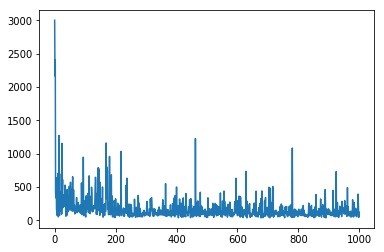

In [47]:
plt.figure()
plt.plot(losses_1)
plt.show()

epoch [1/100], loss:0.01151, avg:0.01151
epoch [2/100], loss:0.01515, avg:0.01333
epoch [3/100], loss:0.01223, avg:0.01296
epoch [4/100], loss:0.00552, avg:0.01110
epoch [5/100], loss:0.00705, avg:0.01029
epoch [6/100], loss:0.00937, avg:0.01014
epoch [7/100], loss:0.00654, avg:0.00962
epoch [8/100], loss:0.00815, avg:0.00944
epoch [9/100], loss:0.00215, avg:0.00863
epoch [10/100], loss:0.00272, avg:0.00804
epoch [11/100], loss:0.00836, avg:0.00772
epoch [12/100], loss:0.00568, avg:0.00678
epoch [13/100], loss:0.00147, avg:0.00570
epoch [14/100], loss:0.00238, avg:0.00539
epoch [15/100], loss:0.00366, avg:0.00505
epoch [16/100], loss:0.00102, avg:0.00421
epoch [17/100], loss:0.00175, avg:0.00373
epoch [18/100], loss:0.00311, avg:0.00323
epoch [19/100], loss:0.00272, avg:0.00329
epoch [20/100], loss:0.00657, avg:0.00367
epoch [21/100], loss:0.00281, avg:0.00312
epoch [22/100], loss:0.00220, avg:0.00277
epoch [23/100], loss:0.00445, avg:0.00307
epoch [24/100], loss:0.00597, avg:0.00343
e

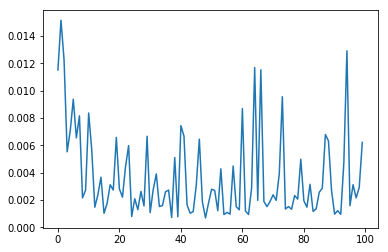

In [202]:
epoch_range = 100
batch_size = 150
learning_rate = 0.0001
seq_len = 51
embedding_size = 8

lstm_ae_1 = lstm_autoencoder2(length, seq_len, embedding_size)
lstm_ae_1.apply(init_lstm_weights)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    lstm_ae_1.parameters(), lr=learning_rate, weight_decay=0.001)

enc, out, losses_1 = train_lstm(lstm_ae_1, electrode_data_train, criterion, optimizer, epoch_range, batch_size)

plt.figure()
plt.plot(losses_1)
plt.show()

## Loss Plot and Reconstruction

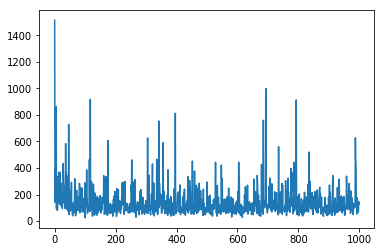

In [37]:
plt.figure()
plt.plot(losses_1)
plt.show()

## Training with embedding size = 10

In [23]:
epoch_range = 3000
batch_size = 150
learning_rate = 0.0001
seq_len = 3
embedding_size = 10

lstm_ae_2 = lstm_autoencoder(length, seq_len, embedding_size)
lstm_ae_2.apply(init_lstm_weights)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    lstm_ae_2.parameters(), lr=learning_rate, weight_decay=0.001)

enc, out, losses_2 = train_lstm(lstm_ae_2, electrode_data_train, criterion, optimizer, epoch_range, batch_size)

epoch [1/3000], loss:2068.49194, avg:2068.49194
epoch [2/3000], loss:2798.49316, avg:2433.49268
epoch [3/3000], loss:370.52106, avg:1745.83545
epoch [4/3000], loss:256.65796, avg:1373.54102
epoch [5/3000], loss:732.40295, avg:1245.31335
epoch [6/3000], loss:213.69432, avg:1073.37683
epoch [7/3000], loss:403.21445, avg:977.63934
epoch [8/3000], loss:821.26166, avg:958.09216
epoch [9/3000], loss:286.40518, avg:883.46027
epoch [10/3000], loss:82.36504, avg:803.35077
epoch [11/3000], loss:304.04077, avg:626.90564
epoch [12/3000], loss:201.34297, avg:367.19064
epoch [13/3000], loss:228.26411, avg:352.96497
epoch [14/3000], loss:84.53524, avg:335.75269
epoch [15/3000], loss:366.73996, avg:299.18637
epoch [16/3000], loss:308.83182, avg:308.70010
epoch [17/3000], loss:243.17340, avg:292.69601
epoch [18/3000], loss:246.77762, avg:235.24760
epoch [19/3000], loss:393.79459, avg:245.98654
epoch [20/3000], loss:222.41043, avg:259.99109
epoch [21/3000], loss:306.78876, avg:260.26590
epoch [22/3000],

epoch [175/3000], loss:188.35437, avg:243.63028
epoch [176/3000], loss:158.29051, avg:246.77231
epoch [177/3000], loss:437.87125, avg:259.88193
epoch [178/3000], loss:68.33395, avg:245.48315
epoch [179/3000], loss:164.58768, avg:201.22813
epoch [180/3000], loss:266.09830, avg:214.49817
epoch [181/3000], loss:191.67505, avg:211.27763
epoch [182/3000], loss:1246.81885, avg:309.91159
epoch [183/3000], loss:324.48959, avg:326.94528
epoch [184/3000], loss:212.67392, avg:325.91931
epoch [185/3000], loss:219.61853, avg:329.04575
epoch [186/3000], loss:166.13988, avg:329.83069
epoch [187/3000], loss:139.38591, avg:299.98218
epoch [188/3000], loss:85.65731, avg:301.71451
epoch [189/3000], loss:177.64650, avg:303.02036
epoch [190/3000], loss:104.43719, avg:286.85428
epoch [191/3000], loss:233.13069, avg:290.99982
epoch [192/3000], loss:167.78928, avg:183.09689
epoch [193/3000], loss:145.08607, avg:165.15652
epoch [194/3000], loss:139.66284, avg:157.85542
epoch [195/3000], loss:140.08020, avg:149

epoch [348/3000], loss:46.50994, avg:101.31740
epoch [349/3000], loss:93.28629, avg:94.68532
epoch [350/3000], loss:703.85406, avg:151.45219
epoch [351/3000], loss:54.73348, avg:153.58546
epoch [352/3000], loss:314.00711, avg:173.72220
epoch [353/3000], loss:45.08348, avg:170.47560
epoch [354/3000], loss:101.40036, avg:175.43610
epoch [355/3000], loss:72.57691, avg:168.12111
epoch [356/3000], loss:30.09402, avg:153.89450
epoch [357/3000], loss:246.75850, avg:170.83041
epoch [358/3000], loss:53.13510, avg:171.49295
epoch [359/3000], loss:123.24563, avg:174.48886
epoch [360/3000], loss:80.68394, avg:112.17185
epoch [361/3000], loss:55.22483, avg:112.22099
epoch [362/3000], loss:101.56893, avg:90.97717
epoch [363/3000], loss:95.23726, avg:95.99255
epoch [364/3000], loss:38.86207, avg:89.73872
epoch [365/3000], loss:58.37756, avg:88.31878
epoch [366/3000], loss:151.10146, avg:100.41953
epoch [367/3000], loss:63.16857, avg:82.06053
epoch [368/3000], loss:108.63331, avg:87.61035
epoch [369/3

epoch [525/3000], loss:50.62070, avg:64.39289
epoch [526/3000], loss:49.60732, avg:64.40553
epoch [527/3000], loss:56.90484, avg:62.02352
epoch [528/3000], loss:106.85909, avg:64.29787
epoch [529/3000], loss:58.85633, avg:61.36816
epoch [530/3000], loss:85.57586, avg:61.17891
epoch [531/3000], loss:53.39769, avg:61.57633
epoch [532/3000], loss:76.97290, avg:64.43861
epoch [533/3000], loss:58.40916, avg:66.18315
epoch [534/3000], loss:46.64098, avg:64.38449
epoch [535/3000], loss:75.77011, avg:66.89943
epoch [536/3000], loss:30.92972, avg:65.03166
epoch [537/3000], loss:56.96862, avg:65.03805
epoch [538/3000], loss:63.50734, avg:60.70287
epoch [539/3000], loss:112.81467, avg:66.09871
epoch [540/3000], loss:49.72335, avg:62.51346
epoch [541/3000], loss:65.39012, avg:63.71270
epoch [542/3000], loss:42.14201, avg:60.22961
epoch [543/3000], loss:44.68472, avg:58.85717
epoch [544/3000], loss:83.97003, avg:62.59007
epoch [545/3000], loss:102.29083, avg:65.24214
epoch [546/3000], loss:120.4681

epoch [703/3000], loss:83.53114, avg:65.44195
epoch [704/3000], loss:51.62004, avg:66.30894
epoch [705/3000], loss:34.11735, avg:65.97723
epoch [706/3000], loss:78.20454, avg:61.46021
epoch [707/3000], loss:74.14901, avg:64.69188
epoch [708/3000], loss:56.53233, avg:57.49359
epoch [709/3000], loss:53.06842, avg:57.04852
epoch [710/3000], loss:44.83430, avg:58.12403
epoch [711/3000], loss:40.88576, avg:54.92336
epoch [712/3000], loss:46.26439, avg:56.32073
epoch [713/3000], loss:51.45749, avg:53.11336
epoch [714/3000], loss:55.23022, avg:53.47438
epoch [715/3000], loss:73.16739, avg:57.37938
epoch [716/3000], loss:77.46695, avg:57.30563
epoch [717/3000], loss:117.95439, avg:61.68616
epoch [718/3000], loss:57.96159, avg:61.82909
epoch [719/3000], loss:121.32641, avg:68.65489
epoch [720/3000], loss:32.30204, avg:67.40166
epoch [721/3000], loss:52.82084, avg:68.59518
epoch [722/3000], loss:35.23083, avg:67.49182
epoch [723/3000], loss:47.52965, avg:67.09904
epoch [724/3000], loss:40.68658,

epoch [881/3000], loss:50.00528, avg:49.26420
epoch [882/3000], loss:53.68006, avg:49.96524
epoch [883/3000], loss:95.54369, avg:55.71522
epoch [884/3000], loss:67.10027, avg:59.28610
epoch [885/3000], loss:64.51591, avg:59.41591
epoch [886/3000], loss:105.32556, avg:66.51244
epoch [887/3000], loss:75.72478, avg:67.81338
epoch [888/3000], loss:59.01780, avg:66.15298
epoch [889/3000], loss:77.30618, avg:68.28156
epoch [890/3000], loss:43.88484, avg:69.21043
epoch [891/3000], loss:53.45560, avg:69.55547
epoch [892/3000], loss:73.25047, avg:71.51251
epoch [893/3000], loss:59.31769, avg:67.88991
epoch [894/3000], loss:31.84706, avg:64.36459
epoch [895/3000], loss:39.85887, avg:61.89888
epoch [896/3000], loss:101.57500, avg:61.52383
epoch [897/3000], loss:106.54531, avg:64.60588
epoch [898/3000], loss:66.86671, avg:65.39077
epoch [899/3000], loss:28.40208, avg:60.50037
epoch [900/3000], loss:33.40255, avg:59.45214
epoch [901/3000], loss:60.66907, avg:60.17348
epoch [902/3000], loss:152.6169

epoch [1058/3000], loss:215.26274, avg:74.15532
epoch [1059/3000], loss:34.57958, avg:70.95798
epoch [1060/3000], loss:104.12387, avg:78.89391
epoch [1061/3000], loss:38.94392, avg:77.92696
epoch [1062/3000], loss:37.36514, avg:75.18906
epoch [1063/3000], loss:53.98749, avg:76.67184
epoch [1064/3000], loss:34.49208, avg:77.28825
epoch [1065/3000], loss:51.62516, avg:70.39778
epoch [1066/3000], loss:66.89864, avg:71.00736
epoch [1067/3000], loss:41.65321, avg:67.89318
epoch [1068/3000], loss:44.59446, avg:50.82636
epoch [1069/3000], loss:106.40253, avg:58.00865
epoch [1070/3000], loss:50.37682, avg:52.63394
epoch [1071/3000], loss:68.34991, avg:55.57454
epoch [1072/3000], loss:31.11205, avg:54.94924
epoch [1073/3000], loss:77.96380, avg:57.34687
epoch [1074/3000], loss:64.36392, avg:60.33406
epoch [1075/3000], loss:44.08296, avg:59.57983
epoch [1076/3000], loss:45.34319, avg:57.42429
epoch [1077/3000], loss:83.35484, avg:61.59445
epoch [1078/3000], loss:41.03810, avg:61.23881
epoch [107

epoch [1233/3000], loss:81.75179, avg:51.35131
epoch [1234/3000], loss:50.91672, avg:53.46365
epoch [1235/3000], loss:49.22768, avg:55.09587
epoch [1236/3000], loss:51.68521, avg:56.06155
epoch [1237/3000], loss:70.30129, avg:58.64891
epoch [1238/3000], loss:93.02119, avg:66.27891
epoch [1239/3000], loss:39.65842, avg:63.42179
epoch [1240/3000], loss:41.73781, avg:61.85368
epoch [1241/3000], loss:48.71735, avg:55.62152
epoch [1242/3000], loss:46.90112, avg:57.39186
epoch [1243/3000], loss:41.26325, avg:53.34301
epoch [1244/3000], loss:16.99306, avg:49.95064
epoch [1245/3000], loss:70.77191, avg:52.10506
epoch [1246/3000], loss:33.11016, avg:50.24756
epoch [1247/3000], loss:37.80294, avg:46.99772
epoch [1248/3000], loss:80.87981, avg:45.78358
epoch [1249/3000], loss:48.76088, avg:46.69383
epoch [1250/3000], loss:61.10901, avg:48.63095
epoch [1251/3000], loss:81.22105, avg:51.88132
epoch [1252/3000], loss:61.30381, avg:53.32159
epoch [1253/3000], loss:27.42043, avg:51.93731
epoch [1254/3

epoch [1408/3000], loss:76.40095, avg:50.76598
epoch [1409/3000], loss:60.05338, avg:50.71658
epoch [1410/3000], loss:57.12440, avg:53.31559
epoch [1411/3000], loss:38.43288, avg:52.01110
epoch [1412/3000], loss:45.49795, avg:53.21563
epoch [1413/3000], loss:36.71994, avg:52.26340
epoch [1414/3000], loss:37.74384, avg:50.65824
epoch [1415/3000], loss:53.41849, avg:51.45432
epoch [1416/3000], loss:84.26702, avg:54.71532
epoch [1417/3000], loss:47.72187, avg:53.73808
epoch [1418/3000], loss:72.86654, avg:53.38463
epoch [1419/3000], loss:89.53459, avg:56.33275
epoch [1420/3000], loss:40.95224, avg:54.71553
epoch [1421/3000], loss:47.36104, avg:55.60836
epoch [1422/3000], loss:51.34764, avg:56.19332
epoch [1423/3000], loss:46.23706, avg:57.14504
epoch [1424/3000], loss:38.60787, avg:57.23144
epoch [1425/3000], loss:78.40594, avg:59.73018
epoch [1426/3000], loss:25.14346, avg:53.81782
epoch [1427/3000], loss:35.32273, avg:52.57791
epoch [1428/3000], loss:33.36288, avg:48.62754
epoch [1429/3

epoch [1583/3000], loss:48.11230, avg:51.62831
epoch [1584/3000], loss:43.87918, avg:53.35177
epoch [1585/3000], loss:52.58002, avg:53.84580
epoch [1586/3000], loss:33.00043, avg:53.05275
epoch [1587/3000], loss:30.86980, avg:50.08772
epoch [1588/3000], loss:88.64754, avg:53.13345
epoch [1589/3000], loss:25.88249, avg:50.79459
epoch [1590/3000], loss:28.14307, avg:50.10457
epoch [1591/3000], loss:38.74162, avg:42.01139
epoch [1592/3000], loss:66.89899, avg:45.67554
epoch [1593/3000], loss:44.97789, avg:45.36210
epoch [1594/3000], loss:25.15785, avg:43.48997
epoch [1595/3000], loss:34.73353, avg:41.70531
epoch [1596/3000], loss:66.82169, avg:45.08744
epoch [1597/3000], loss:45.97924, avg:46.59839
epoch [1598/3000], loss:40.83427, avg:41.81706
epoch [1599/3000], loss:53.00080, avg:44.52890
epoch [1600/3000], loss:36.70520, avg:45.38511
epoch [1601/3000], loss:48.91699, avg:46.40265
epoch [1602/3000], loss:30.44136, avg:42.75688
epoch [1603/3000], loss:24.70231, avg:40.72932
epoch [1604/3

epoch [1758/3000], loss:58.29665, avg:45.46934
epoch [1759/3000], loss:103.68784, avg:52.92937
epoch [1760/3000], loss:35.13325, avg:52.92916
epoch [1761/3000], loss:39.43988, avg:51.85582
epoch [1762/3000], loss:31.67927, avg:52.02251
epoch [1763/3000], loss:25.14125, avg:49.69379
epoch [1764/3000], loss:45.81724, avg:49.97922
epoch [1765/3000], loss:57.74996, avg:52.80530
epoch [1766/3000], loss:19.45259, avg:45.45980
epoch [1767/3000], loss:33.26423, avg:44.96621
epoch [1768/3000], loss:59.86165, avg:45.12272
epoch [1769/3000], loss:34.12946, avg:38.16688
epoch [1770/3000], loss:34.52376, avg:38.10593
epoch [1771/3000], loss:29.44758, avg:37.10670
epoch [1772/3000], loss:41.68400, avg:38.10717
epoch [1773/3000], loss:44.07077, avg:40.00013
epoch [1774/3000], loss:37.77266, avg:39.19567
epoch [1775/3000], loss:58.17214, avg:39.23788
epoch [1776/3000], loss:44.93570, avg:41.78619
epoch [1777/3000], loss:41.61356, avg:42.62113
epoch [1778/3000], loss:53.63350, avg:41.99831
epoch [1779/

epoch [1933/3000], loss:67.55821, avg:36.92843
epoch [1934/3000], loss:30.46323, avg:37.22253
epoch [1935/3000], loss:31.07132, avg:36.96004
epoch [1936/3000], loss:41.27529, avg:38.22097
epoch [1937/3000], loss:42.14021, avg:38.90034
epoch [1938/3000], loss:34.28726, avg:39.92901
epoch [1939/3000], loss:42.43417, avg:39.70598
epoch [1940/3000], loss:32.68169, avg:38.91464
epoch [1941/3000], loss:24.71208, avg:37.02640
epoch [1942/3000], loss:22.42293, avg:36.90464
epoch [1943/3000], loss:72.62734, avg:37.41155
epoch [1944/3000], loss:75.49388, avg:41.91462
epoch [1945/3000], loss:53.84050, avg:44.19154
epoch [1946/3000], loss:27.98370, avg:42.86238
epoch [1947/3000], loss:40.03829, avg:42.65219
epoch [1948/3000], loss:20.30584, avg:41.25404
epoch [1949/3000], loss:24.97405, avg:39.50803
epoch [1950/3000], loss:38.79543, avg:40.11941
epoch [1951/3000], loss:66.69962, avg:44.31816
epoch [1952/3000], loss:29.21445, avg:44.99731
epoch [1953/3000], loss:38.12626, avg:41.54720
epoch [1954/3

epoch [2108/3000], loss:41.74939, avg:33.34861
epoch [2109/3000], loss:54.79392, avg:36.59855
epoch [2110/3000], loss:47.33661, avg:39.11763
epoch [2111/3000], loss:38.11486, avg:39.24557
epoch [2112/3000], loss:48.59976, avg:40.68724
epoch [2113/3000], loss:41.42540, avg:41.11464
epoch [2114/3000], loss:32.64782, avg:41.66975
epoch [2115/3000], loss:27.76260, avg:42.09764
epoch [2116/3000], loss:41.16414, avg:41.31773
epoch [2117/3000], loss:36.39396, avg:40.99885
epoch [2118/3000], loss:53.24655, avg:42.14856
epoch [2119/3000], loss:29.91284, avg:39.66045
epoch [2120/3000], loss:39.56939, avg:38.88374
epoch [2121/3000], loss:30.81318, avg:38.15356
epoch [2122/3000], loss:41.32447, avg:37.42603
epoch [2123/3000], loss:41.79957, avg:37.46345
epoch [2124/3000], loss:30.80861, avg:37.27953
epoch [2125/3000], loss:37.09857, avg:38.21313
epoch [2126/3000], loss:43.97957, avg:38.49467
epoch [2127/3000], loss:32.24403, avg:38.07968
epoch [2128/3000], loss:33.66075, avg:36.12110
epoch [2129/3

epoch [2283/3000], loss:66.16653, avg:45.61185
epoch [2284/3000], loss:43.84764, avg:44.96339
epoch [2285/3000], loss:33.79388, avg:45.19091
epoch [2286/3000], loss:18.38604, avg:43.42138
epoch [2287/3000], loss:21.52730, avg:42.36480
epoch [2288/3000], loss:47.36868, avg:43.67554
epoch [2289/3000], loss:49.59934, avg:38.35091
epoch [2290/3000], loss:34.84536, avg:38.78889
epoch [2291/3000], loss:58.03140, avg:40.69968
epoch [2292/3000], loss:54.55690, avg:42.81231
epoch [2293/3000], loss:22.74709, avg:38.47036
epoch [2294/3000], loss:38.89504, avg:37.97511
epoch [2295/3000], loss:49.75306, avg:39.57102
epoch [2296/3000], loss:23.39813, avg:40.07223
epoch [2297/3000], loss:30.75752, avg:40.99525
epoch [2298/3000], loss:34.99143, avg:39.75753
epoch [2299/3000], loss:68.34643, avg:41.63223
epoch [2300/3000], loss:28.32035, avg:40.97973
epoch [2301/3000], loss:43.73246, avg:39.54984
epoch [2302/3000], loss:28.12964, avg:36.90711
epoch [2303/3000], loss:33.86592, avg:38.01900
epoch [2304/3

epoch [2458/3000], loss:37.03834, avg:34.65816
epoch [2459/3000], loss:15.89350, avg:32.23439
epoch [2460/3000], loss:17.25151, avg:30.26233
epoch [2461/3000], loss:20.56602, avg:29.35662
epoch [2462/3000], loss:67.77940, avg:32.23814
epoch [2463/3000], loss:24.93244, avg:31.29966
epoch [2464/3000], loss:38.48104, avg:31.99123
epoch [2465/3000], loss:39.07399, avg:31.76373
epoch [2466/3000], loss:20.98003, avg:31.38049
epoch [2467/3000], loss:39.97153, avg:32.19678
epoch [2468/3000], loss:24.45016, avg:30.93796
epoch [2469/3000], loss:38.26439, avg:33.17505
epoch [2470/3000], loss:44.27810, avg:35.87771
epoch [2471/3000], loss:23.47295, avg:36.16840
epoch [2472/3000], loss:38.73005, avg:33.26347
epoch [2473/3000], loss:26.60740, avg:33.43096
epoch [2474/3000], loss:36.24744, avg:33.20760
epoch [2475/3000], loss:37.58865, avg:33.05907
epoch [2476/3000], loss:19.90727, avg:32.95179
epoch [2477/3000], loss:27.36927, avg:31.69156
epoch [2478/3000], loss:24.94546, avg:31.74110
epoch [2479/3

epoch [2633/3000], loss:32.71941, avg:29.67898
epoch [2634/3000], loss:50.30896, avg:32.39658
epoch [2635/3000], loss:60.26760, avg:36.85491
epoch [2636/3000], loss:35.57653, avg:37.19055
epoch [2637/3000], loss:29.69466, avg:37.87193
epoch [2638/3000], loss:42.78589, avg:36.58864
epoch [2639/3000], loss:38.46196, avg:37.83977
epoch [2640/3000], loss:18.27081, avg:35.29497
epoch [2641/3000], loss:37.54944, avg:37.18387
epoch [2642/3000], loss:36.33597, avg:38.19712
epoch [2643/3000], loss:48.45036, avg:39.77021
epoch [2644/3000], loss:26.31140, avg:37.37046
epoch [2645/3000], loss:48.86766, avg:36.23047
epoch [2646/3000], loss:19.89718, avg:34.66254
epoch [2647/3000], loss:27.21427, avg:34.41450
epoch [2648/3000], loss:34.17846, avg:33.55375
epoch [2649/3000], loss:48.18835, avg:34.52639
epoch [2650/3000], loss:17.58139, avg:34.45745
epoch [2651/3000], loss:38.94185, avg:34.59669
epoch [2652/3000], loss:30.73173, avg:34.03626
epoch [2653/3000], loss:23.05942, avg:31.49717
epoch [2654/3

epoch [2808/3000], loss:15.53017, avg:29.26223
epoch [2809/3000], loss:26.38250, avg:29.62803
epoch [2810/3000], loss:30.17829, avg:29.54940
epoch [2811/3000], loss:26.59767, avg:27.87079
epoch [2812/3000], loss:32.05010, avg:28.43914
epoch [2813/3000], loss:46.99874, avg:31.08790
epoch [2814/3000], loss:31.51835, avg:29.93785
epoch [2815/3000], loss:44.34352, avg:32.48478
epoch [2816/3000], loss:29.72050, avg:30.66699
epoch [2817/3000], loss:29.35579, avg:31.26756
epoch [2818/3000], loss:32.46456, avg:32.96100
epoch [2819/3000], loss:40.79979, avg:34.40273
epoch [2820/3000], loss:32.86510, avg:34.67141
epoch [2821/3000], loss:32.66494, avg:35.27814
epoch [2822/3000], loss:41.58502, avg:36.23163
epoch [2823/3000], loss:18.92885, avg:33.42464
epoch [2824/3000], loss:30.39206, avg:33.31202
epoch [2825/3000], loss:21.11599, avg:30.98926
epoch [2826/3000], loss:55.99199, avg:33.61641
epoch [2827/3000], loss:24.04369, avg:33.08520
epoch [2828/3000], loss:29.01943, avg:32.74069
epoch [2829/3

epoch [2983/3000], loss:36.62662, avg:30.82759
epoch [2984/3000], loss:18.96017, avg:30.77238
epoch [2985/3000], loss:27.31488, avg:30.76803
epoch [2986/3000], loss:50.01979, avg:31.63661
epoch [2987/3000], loss:39.00555, avg:30.85594
epoch [2988/3000], loss:18.84346, avg:29.58985
epoch [2989/3000], loss:30.04349, avg:30.36259
epoch [2990/3000], loss:23.46666, avg:28.97237
epoch [2991/3000], loss:21.80763, avg:29.44758
epoch [2992/3000], loss:53.04572, avg:31.91340
epoch [2993/3000], loss:22.64745, avg:30.51548
epoch [2994/3000], loss:19.72937, avg:30.59240
epoch [2995/3000], loss:30.77074, avg:30.93799
epoch [2996/3000], loss:34.37878, avg:29.37389
epoch [2997/3000], loss:27.92231, avg:28.26556
epoch [2998/3000], loss:20.56192, avg:28.43741
epoch [2999/3000], loss:23.76095, avg:27.80915
epoch [3000/3000], loss:40.89795, avg:29.55228


In [24]:
torch.save(lstm_ae_2, 'models/visapy/lstm_10.pt') #Saving the autoencoder model

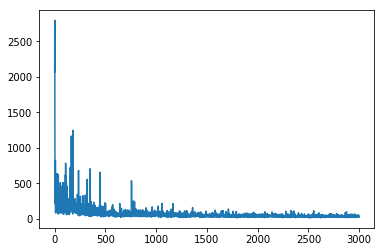

In [25]:
plt.figure()
plt.plot(losses_2)
plt.show()

## Training with embedding size = 8

In [26]:
epoch_range = 3000
batch_size = 150
learning_rate = 0.0001
seq_len = 3
embedding_size = 8

lstm_ae_3 = lstm_autoencoder(length, seq_len, embedding_size)
lstm_ae_3.apply(init_lstm_weights)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    lstm_ae_3.parameters(), lr=learning_rate, weight_decay=0.001)

enc, out, losses_3 = train_lstm(lstm_ae_3, electrode_data_train, criterion, optimizer, epoch_range, batch_size)

epoch [1/3000], loss:2309.21362, avg:2309.21362
epoch [2/3000], loss:1002.95673, avg:1656.08521
epoch [3/3000], loss:614.50934, avg:1308.89319
epoch [4/3000], loss:227.21062, avg:1038.47253
epoch [5/3000], loss:109.90937, avg:852.75989
epoch [6/3000], loss:184.38257, avg:741.36359
epoch [7/3000], loss:148.76344, avg:656.70648
epoch [8/3000], loss:93.95709, avg:586.36279
epoch [9/3000], loss:122.10877, avg:534.77905
epoch [10/3000], loss:221.68457, avg:503.46957
epoch [11/3000], loss:263.79657, avg:298.92792
epoch [12/3000], loss:125.98957, avg:211.23117
epoch [13/3000], loss:193.34421, avg:169.11469
epoch [14/3000], loss:435.12189, avg:189.90581
epoch [15/3000], loss:328.42914, avg:211.75778
epoch [16/3000], loss:105.00912, avg:203.82045
epoch [17/3000], loss:266.40607, avg:215.58472
epoch [18/3000], loss:219.70750, avg:228.15976
epoch [19/3000], loss:292.92001, avg:245.24088
epoch [20/3000], loss:97.62177, avg:232.83459
epoch [21/3000], loss:109.72659, avg:217.42758
epoch [22/3000], l

epoch [175/3000], loss:88.09687, avg:169.82275
epoch [176/3000], loss:70.53667, avg:170.98897
epoch [177/3000], loss:104.56602, avg:152.94153
epoch [178/3000], loss:210.72469, avg:141.23038
epoch [179/3000], loss:147.89740, avg:138.22957
epoch [180/3000], loss:217.01707, avg:149.40022
epoch [181/3000], loss:423.43250, avg:180.53574
epoch [182/3000], loss:254.09673, avg:187.85626
epoch [183/3000], loss:44.86372, avg:167.24182
epoch [184/3000], loss:154.58626, avg:171.58180
epoch [185/3000], loss:109.52389, avg:173.72450
epoch [186/3000], loss:148.86743, avg:181.55759
epoch [187/3000], loss:487.16943, avg:219.81792
epoch [188/3000], loss:90.98315, avg:207.84378
epoch [189/3000], loss:110.15945, avg:204.06998
epoch [190/3000], loss:45.84377, avg:186.95262
epoch [191/3000], loss:165.76720, avg:161.18610
epoch [192/3000], loss:100.83575, avg:145.86002
epoch [193/3000], loss:54.96597, avg:146.87022
epoch [194/3000], loss:145.78560, avg:145.99017
epoch [195/3000], loss:116.35600, avg:146.6733

epoch [348/3000], loss:161.26753, avg:172.94966
epoch [349/3000], loss:71.17964, avg:161.97243
epoch [350/3000], loss:146.09866, avg:145.52069
epoch [351/3000], loss:87.66125, avg:141.56487
epoch [352/3000], loss:195.28072, avg:155.19810
epoch [353/3000], loss:104.59250, avg:159.56912
epoch [354/3000], loss:94.04714, avg:148.88467
epoch [355/3000], loss:98.85671, avg:134.33104
epoch [356/3000], loss:28.56465, avg:114.13286
epoch [357/3000], loss:201.46854, avg:118.90173
epoch [358/3000], loss:60.70847, avg:108.84583
epoch [359/3000], loss:111.18430, avg:112.84630
epoch [360/3000], loss:76.87933, avg:105.92435
epoch [361/3000], loss:196.39034, avg:116.79728
epoch [362/3000], loss:103.61428, avg:107.63063
epoch [363/3000], loss:125.59062, avg:109.73043
epoch [364/3000], loss:71.61731, avg:107.48745
epoch [365/3000], loss:103.85537, avg:107.98732
epoch [366/3000], loss:164.82587, avg:121.61345
epoch [367/3000], loss:63.59010, avg:107.82560
epoch [368/3000], loss:86.26099, avg:110.38084
ep

epoch [522/3000], loss:46.34420, avg:135.14774
epoch [523/3000], loss:134.43245, avg:140.50980
epoch [524/3000], loss:145.62724, avg:147.28018
epoch [525/3000], loss:62.42382, avg:144.93967
epoch [526/3000], loss:122.57938, avg:124.84955
epoch [527/3000], loss:157.57648, avg:131.39902
epoch [528/3000], loss:85.58443, avg:103.37013
epoch [529/3000], loss:69.70811, avg:101.79591
epoch [530/3000], loss:35.71423, avg:90.62302
epoch [531/3000], loss:43.73014, avg:90.37205
epoch [532/3000], loss:40.06427, avg:89.74406
epoch [533/3000], loss:186.80371, avg:94.98119
epoch [534/3000], loss:60.12444, avg:86.43090
epoch [535/3000], loss:52.31675, avg:85.42020
epoch [536/3000], loss:88.52972, avg:82.01524
epoch [537/3000], loss:288.62378, avg:95.11996
epoch [538/3000], loss:84.94603, avg:95.05611
epoch [539/3000], loss:53.06253, avg:93.39156
epoch [540/3000], loss:65.21836, avg:96.34198
epoch [541/3000], loss:45.30706, avg:96.49967
epoch [542/3000], loss:76.28819, avg:100.12207
epoch [543/3000], l

epoch [699/3000], loss:108.38309, avg:76.83035
epoch [700/3000], loss:79.60492, avg:73.88260
epoch [701/3000], loss:65.95979, avg:73.54234
epoch [702/3000], loss:62.04834, avg:77.84283
epoch [703/3000], loss:40.57421, avg:72.93670
epoch [704/3000], loss:46.46360, avg:70.51267
epoch [705/3000], loss:34.99300, avg:64.30804
epoch [706/3000], loss:45.94125, avg:63.31981
epoch [707/3000], loss:57.45639, avg:60.00108
epoch [708/3000], loss:55.72732, avg:59.71519
epoch [709/3000], loss:37.96856, avg:52.67374
epoch [710/3000], loss:43.46458, avg:49.05970
epoch [711/3000], loss:34.92607, avg:45.95634
epoch [712/3000], loss:54.61403, avg:45.21290
epoch [713/3000], loss:105.79789, avg:51.73527
epoch [714/3000], loss:240.61934, avg:71.15084
epoch [715/3000], loss:64.81415, avg:74.13296
epoch [716/3000], loss:37.14439, avg:73.25327
epoch [717/3000], loss:81.10453, avg:75.61809
epoch [718/3000], loss:66.82349, avg:76.72771
epoch [719/3000], loss:61.93885, avg:79.12473
epoch [720/3000], loss:48.81956

epoch [877/3000], loss:69.95676, avg:59.75572
epoch [878/3000], loss:68.17921, avg:53.97063
epoch [879/3000], loss:43.11547, avg:53.70644
epoch [880/3000], loss:54.27068, avg:55.28686
epoch [881/3000], loss:32.05275, avg:52.43522
epoch [882/3000], loss:61.19863, avg:53.22646
epoch [883/3000], loss:64.36372, avg:54.07905
epoch [884/3000], loss:31.50131, avg:51.66230
epoch [885/3000], loss:41.77513, avg:52.09606
epoch [886/3000], loss:45.81018, avg:51.22238
epoch [887/3000], loss:79.40930, avg:52.16764
epoch [888/3000], loss:31.23838, avg:48.47356
epoch [889/3000], loss:81.17439, avg:52.27945
epoch [890/3000], loss:46.12948, avg:51.46532
epoch [891/3000], loss:69.52979, avg:55.21303
epoch [892/3000], loss:44.88478, avg:53.58165
epoch [893/3000], loss:73.55436, avg:54.50071
epoch [894/3000], loss:63.68074, avg:57.71865
epoch [895/3000], loss:70.65891, avg:60.60704
epoch [896/3000], loss:70.18121, avg:63.04414
epoch [897/3000], loss:154.30409, avg:70.53362
epoch [898/3000], loss:57.03339, 

epoch [1054/3000], loss:74.81049, avg:52.38685
epoch [1055/3000], loss:33.89368, avg:50.82036
epoch [1056/3000], loss:37.99722, avg:50.54391
epoch [1057/3000], loss:88.82047, avg:47.00639
epoch [1058/3000], loss:28.15212, avg:47.03321
epoch [1059/3000], loss:85.99920, avg:50.33946
epoch [1060/3000], loss:18.64461, avg:48.47630
epoch [1061/3000], loss:181.38699, avg:63.13910
epoch [1062/3000], loss:51.42721, avg:63.46255
epoch [1063/3000], loss:91.08624, avg:69.22182
epoch [1064/3000], loss:37.70335, avg:65.51112
epoch [1065/3000], loss:33.47273, avg:65.46902
epoch [1066/3000], loss:31.84907, avg:64.85420
epoch [1067/3000], loss:29.01268, avg:58.87342
epoch [1068/3000], loss:51.16674, avg:61.17488
epoch [1069/3000], loss:45.70112, avg:57.14507
epoch [1070/3000], loss:49.65950, avg:60.24656
epoch [1071/3000], loss:55.55311, avg:47.66317
epoch [1072/3000], loss:44.88785, avg:47.00924
epoch [1073/3000], loss:66.01781, avg:44.50239
epoch [1074/3000], loss:58.95911, avg:46.62797
epoch [1075/

epoch [1229/3000], loss:106.20013, avg:51.17532
epoch [1230/3000], loss:46.42556, avg:51.59359
epoch [1231/3000], loss:33.05203, avg:48.01713
epoch [1232/3000], loss:43.92156, avg:47.60092
epoch [1233/3000], loss:41.66654, avg:47.46365
epoch [1234/3000], loss:31.58340, avg:47.60859
epoch [1235/3000], loss:24.96507, avg:45.52708
epoch [1236/3000], loss:40.39139, avg:45.46269
epoch [1237/3000], loss:39.03369, avg:44.33477
epoch [1238/3000], loss:49.30042, avg:45.65398
epoch [1239/3000], loss:41.27044, avg:39.16101
epoch [1240/3000], loss:23.82496, avg:36.90095
epoch [1241/3000], loss:40.03600, avg:37.59935
epoch [1242/3000], loss:70.14603, avg:40.22179
epoch [1243/3000], loss:49.56158, avg:41.01130
epoch [1244/3000], loss:50.34826, avg:42.88778
epoch [1245/3000], loss:64.97868, avg:46.88915
epoch [1246/3000], loss:37.36742, avg:46.58675
epoch [1247/3000], loss:53.58709, avg:48.04209
epoch [1248/3000], loss:52.04597, avg:48.31664
epoch [1249/3000], loss:77.72850, avg:51.96245
epoch [1250/

epoch [1404/3000], loss:42.99942, avg:47.39023
epoch [1405/3000], loss:57.51387, avg:49.35020
epoch [1406/3000], loss:40.08098, avg:48.70222
epoch [1407/3000], loss:49.01888, avg:49.44064
epoch [1408/3000], loss:68.36371, avg:51.03701
epoch [1409/3000], loss:61.93811, avg:52.17350
epoch [1410/3000], loss:41.49910, avg:51.49785
epoch [1411/3000], loss:69.84399, avg:55.05527
epoch [1412/3000], loss:32.68925, avg:52.25704
epoch [1413/3000], loss:38.89209, avg:50.28394
epoch [1414/3000], loss:49.64089, avg:50.94808
epoch [1415/3000], loss:104.92529, avg:55.68923
epoch [1416/3000], loss:22.57561, avg:53.93869
epoch [1417/3000], loss:46.38614, avg:53.67542
epoch [1418/3000], loss:106.71017, avg:57.51006
epoch [1419/3000], loss:35.00033, avg:54.81628
epoch [1420/3000], loss:42.88167, avg:54.95455
epoch [1421/3000], loss:26.86480, avg:50.65663
epoch [1422/3000], loss:32.40812, avg:50.62851
epoch [1423/3000], loss:49.78839, avg:51.71814
epoch [1424/3000], loss:33.07190, avg:50.06124
epoch [1425

epoch [1579/3000], loss:45.48869, avg:46.53746
epoch [1580/3000], loss:51.62543, avg:48.85968
epoch [1581/3000], loss:29.52877, avg:46.91595
epoch [1582/3000], loss:72.89048, avg:42.90963
epoch [1583/3000], loss:29.75830, avg:42.65700
epoch [1584/3000], loss:35.31064, avg:42.53443
epoch [1585/3000], loss:28.79201, avg:42.52299
epoch [1586/3000], loss:39.80391, avg:43.35104
epoch [1587/3000], loss:31.37420, avg:40.80300
epoch [1588/3000], loss:36.49115, avg:40.10636
epoch [1589/3000], loss:65.14055, avg:42.07154
epoch [1590/3000], loss:49.83140, avg:41.89214
epoch [1591/3000], loss:68.44335, avg:45.78360
epoch [1592/3000], loss:52.90587, avg:43.78514
epoch [1593/3000], loss:26.50987, avg:43.46030
epoch [1594/3000], loss:31.81721, avg:43.11095
epoch [1595/3000], loss:114.04917, avg:51.63667
epoch [1596/3000], loss:38.83334, avg:51.53961
epoch [1597/3000], loss:23.25887, avg:50.72808
epoch [1598/3000], loss:45.93184, avg:51.67215
epoch [1599/3000], loss:19.62458, avg:47.12055
epoch [1600/

epoch [1754/3000], loss:33.07385, avg:38.85275
epoch [1755/3000], loss:34.29507, avg:36.58605
epoch [1756/3000], loss:63.27189, avg:40.40316
epoch [1757/3000], loss:39.90830, avg:40.82262
epoch [1758/3000], loss:44.87745, avg:43.07905
epoch [1759/3000], loss:48.57524, avg:40.91752
epoch [1760/3000], loss:31.07981, avg:40.48519
epoch [1761/3000], loss:35.66343, avg:39.82730
epoch [1762/3000], loss:32.35890, avg:40.26899
epoch [1763/3000], loss:45.73771, avg:40.88416
epoch [1764/3000], loss:31.44136, avg:40.72091
epoch [1765/3000], loss:43.67429, avg:41.65884
epoch [1766/3000], loss:37.04632, avg:39.03629
epoch [1767/3000], loss:25.01009, avg:37.54646
epoch [1768/3000], loss:43.52464, avg:37.41118
epoch [1769/3000], loss:49.20654, avg:37.47431
epoch [1770/3000], loss:44.26311, avg:38.79264
epoch [1771/3000], loss:42.44547, avg:39.47084
epoch [1772/3000], loss:32.03424, avg:39.43838
epoch [1773/3000], loss:32.00908, avg:38.06551
epoch [1774/3000], loss:29.58415, avg:37.87980
epoch [1775/3

epoch [1929/3000], loss:59.05343, avg:37.53714
epoch [1930/3000], loss:21.06592, avg:37.09354
epoch [1931/3000], loss:34.70608, avg:37.76143
epoch [1932/3000], loss:28.18977, avg:36.94135
epoch [1933/3000], loss:49.80223, avg:39.06648
epoch [1934/3000], loss:60.03558, avg:42.68655
epoch [1935/3000], loss:25.57807, avg:39.15297
epoch [1936/3000], loss:19.28105, avg:37.22171
epoch [1937/3000], loss:31.47143, avg:36.40635
epoch [1938/3000], loss:35.08714, avg:36.42707
epoch [1939/3000], loss:27.92493, avg:33.31422
epoch [1940/3000], loss:26.31549, avg:33.83918
epoch [1941/3000], loss:26.06498, avg:32.97507
epoch [1942/3000], loss:21.35313, avg:32.29140
epoch [1943/3000], loss:43.04400, avg:31.61558
epoch [1944/3000], loss:26.85039, avg:28.29706
epoch [1945/3000], loss:37.38069, avg:29.47732
epoch [1946/3000], loss:40.93265, avg:31.64248
epoch [1947/3000], loss:67.29227, avg:35.22457
epoch [1948/3000], loss:41.43869, avg:35.85972
epoch [1949/3000], loss:41.65499, avg:37.23273
epoch [1950/3

epoch [2104/3000], loss:59.17749, avg:54.85121
epoch [2105/3000], loss:63.53928, avg:54.13540
epoch [2106/3000], loss:39.05716, avg:53.56620
epoch [2107/3000], loss:37.69785, avg:53.60210
epoch [2108/3000], loss:26.89039, avg:53.66575
epoch [2109/3000], loss:28.93582, avg:50.53437
epoch [2110/3000], loss:90.91570, avg:55.10374
epoch [2111/3000], loss:32.69292, avg:49.29551
epoch [2112/3000], loss:22.78616, avg:46.90943
epoch [2113/3000], loss:42.47064, avg:44.41634
epoch [2114/3000], loss:48.26296, avg:43.32489
epoch [2115/3000], loss:48.83747, avg:41.85471
epoch [2116/3000], loss:35.13893, avg:41.46288
epoch [2117/3000], loss:75.55410, avg:45.24851
epoch [2118/3000], loss:20.69305, avg:44.62878
epoch [2119/3000], loss:48.78637, avg:46.61383
epoch [2120/3000], loss:42.55206, avg:41.77747
epoch [2121/3000], loss:35.78104, avg:42.08628
epoch [2122/3000], loss:19.36802, avg:41.74446
epoch [2123/3000], loss:22.21154, avg:39.71856
epoch [2124/3000], loss:36.68980, avg:38.56124
epoch [2125/3

epoch [2279/3000], loss:40.19672, avg:36.63221
epoch [2280/3000], loss:37.05954, avg:35.73306
epoch [2281/3000], loss:57.95294, avg:37.67511
epoch [2282/3000], loss:36.73239, avg:39.15435
epoch [2283/3000], loss:32.03621, avg:39.37810
epoch [2284/3000], loss:34.76461, avg:39.85759
epoch [2285/3000], loss:56.86507, avg:41.74965
epoch [2286/3000], loss:23.99023, avg:39.03698
epoch [2287/3000], loss:33.47480, avg:39.54629
epoch [2288/3000], loss:32.49926, avg:38.55718
epoch [2289/3000], loss:70.84399, avg:41.62191
epoch [2290/3000], loss:36.97342, avg:41.61329
epoch [2291/3000], loss:39.05442, avg:39.72344
epoch [2292/3000], loss:82.20534, avg:44.27073
epoch [2293/3000], loss:32.02872, avg:44.26999
epoch [2294/3000], loss:27.96902, avg:43.59043
epoch [2295/3000], loss:38.08783, avg:41.71270
epoch [2296/3000], loss:44.42355, avg:43.75603
epoch [2297/3000], loss:39.10951, avg:44.31951
epoch [2298/3000], loss:38.74602, avg:44.94418
epoch [2299/3000], loss:62.32099, avg:44.09188
epoch [2300/3

epoch [2454/3000], loss:40.30754, avg:40.09058
epoch [2455/3000], loss:36.64097, avg:40.79836
epoch [2456/3000], loss:56.95703, avg:43.17480
epoch [2457/3000], loss:13.95350, avg:41.22267
epoch [2458/3000], loss:23.93895, avg:40.18760
epoch [2459/3000], loss:41.65922, avg:41.53223
epoch [2460/3000], loss:55.50562, avg:43.76030
epoch [2461/3000], loss:34.16579, avg:41.62991
epoch [2462/3000], loss:36.53052, avg:41.09542
epoch [2463/3000], loss:16.68920, avg:35.63484
epoch [2464/3000], loss:43.98197, avg:36.00228
epoch [2465/3000], loss:48.55966, avg:37.19415
epoch [2466/3000], loss:25.04317, avg:34.00276
epoch [2467/3000], loss:60.47068, avg:38.65448
epoch [2468/3000], loss:39.37002, avg:40.19758
epoch [2469/3000], loss:19.37333, avg:37.96899
epoch [2470/3000], loss:27.20013, avg:35.13845
epoch [2471/3000], loss:34.79224, avg:35.20109
epoch [2472/3000], loss:21.17158, avg:33.66520
epoch [2473/3000], loss:23.13618, avg:34.30989
epoch [2474/3000], loss:66.59522, avg:36.57122
epoch [2475/3

epoch [2629/3000], loss:29.53788, avg:41.38683
epoch [2630/3000], loss:35.13667, avg:39.75706
epoch [2631/3000], loss:44.00965, avg:39.10396
epoch [2632/3000], loss:31.56607, avg:39.97863
epoch [2633/3000], loss:37.67386, avg:39.33583
epoch [2634/3000], loss:35.19919, avg:40.64042
epoch [2635/3000], loss:20.64655, avg:39.55912
epoch [2636/3000], loss:47.63600, avg:39.81805
epoch [2637/3000], loss:26.72123, avg:35.00317
epoch [2638/3000], loss:25.65574, avg:33.37828
epoch [2639/3000], loss:29.20523, avg:33.34502
epoch [2640/3000], loss:25.25052, avg:32.35640
epoch [2641/3000], loss:43.56932, avg:32.31237
epoch [2642/3000], loss:14.45036, avg:30.60080
epoch [2643/3000], loss:27.56757, avg:29.59017
epoch [2644/3000], loss:18.63251, avg:27.93351
epoch [2645/3000], loss:31.46228, avg:29.01508
epoch [2646/3000], loss:42.95348, avg:28.54682
epoch [2647/3000], loss:42.05684, avg:30.08038
epoch [2648/3000], loss:33.69914, avg:30.88472
epoch [2649/3000], loss:35.40242, avg:31.50444
epoch [2650/3

epoch [2804/3000], loss:26.47985, avg:43.94285
epoch [2805/3000], loss:37.52984, avg:40.56754
epoch [2806/3000], loss:25.03052, avg:37.19888
epoch [2807/3000], loss:35.18273, avg:38.51409
epoch [2808/3000], loss:22.18122, avg:37.83555
epoch [2809/3000], loss:40.29877, avg:38.97955
epoch [2810/3000], loss:56.05679, avg:38.27993
epoch [2811/3000], loss:39.94587, avg:35.31255
epoch [2812/3000], loss:51.22739, avg:38.44237
epoch [2813/3000], loss:28.56681, avg:36.24998
epoch [2814/3000], loss:19.81410, avg:35.58340
epoch [2815/3000], loss:45.51917, avg:36.38233
epoch [2816/3000], loss:29.85545, avg:36.86483
epoch [2817/3000], loss:44.00107, avg:37.74666
epoch [2818/3000], loss:52.20500, avg:40.74904
epoch [2819/3000], loss:32.38803, avg:39.95797
epoch [2820/3000], loss:48.22113, avg:39.17440
epoch [2821/3000], loss:75.38126, avg:42.71794
epoch [2822/3000], loss:29.35552, avg:40.53075
epoch [2823/3000], loss:27.45884, avg:40.41996
epoch [2824/3000], loss:30.15369, avg:41.45391
epoch [2825/3

epoch [2979/3000], loss:39.53945, avg:40.87562
epoch [2980/3000], loss:26.07696, avg:41.63816
epoch [2981/3000], loss:51.78981, avg:44.46880
epoch [2982/3000], loss:63.23488, avg:46.26070
epoch [2983/3000], loss:26.09566, avg:44.13545
epoch [2984/3000], loss:24.52368, avg:41.98512
epoch [2985/3000], loss:24.99594, avg:41.68194
epoch [2986/3000], loss:52.23783, avg:40.95454
epoch [2987/3000], loss:39.71813, avg:38.34612
epoch [2988/3000], loss:23.78121, avg:37.19936
epoch [2989/3000], loss:22.47372, avg:35.49279
epoch [2990/3000], loss:25.50324, avg:35.43541
epoch [2991/3000], loss:53.62365, avg:35.61880
epoch [2992/3000], loss:29.25111, avg:32.22042
epoch [2993/3000], loss:38.61932, avg:33.47279
epoch [2994/3000], loss:56.87444, avg:36.70786
epoch [2995/3000], loss:26.72709, avg:36.88097
epoch [2996/3000], loss:36.27584, avg:35.28477
epoch [2997/3000], loss:43.82948, avg:35.69591
epoch [2998/3000], loss:33.57204, avg:36.67500
epoch [2999/3000], loss:39.20960, avg:38.34858
epoch [3000/3

In [27]:
torch.save(lstm_ae_3, 'models/visapy/lstm_8.pt') #Saving the autoencoder model

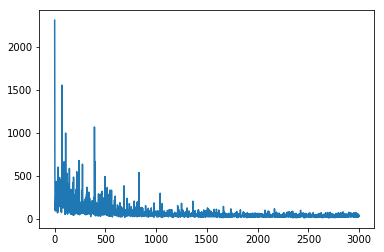

In [28]:
plt.figure()
plt.plot(losses_3)
plt.show()

## Training with embedding size = 6

In [48]:
epoch_range = 3000
batch_size = 150
learning_rate = 0.0001
seq_len = 3
embedding_size = 6

lstm_ae_4 = lstm_autoencoder(length, seq_len, embedding_size)
lstm_ae_4.apply(init_lstm_weights)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    lstm_ae_4.parameters(), lr=learning_rate, weight_decay=0.001)

enc, out, losses_4 = train_lstm(lstm_ae_4, electrode_data_train, criterion, optimizer, epoch_range, batch_size)

epoch [1/3000], loss:2208.93896, avg:2208.93896
epoch [2/3000], loss:652.05438, avg:1430.49670
epoch [3/3000], loss:766.68805, avg:1209.22717
epoch [4/3000], loss:478.19000, avg:1026.46790
epoch [5/3000], loss:513.88202, avg:923.95068
epoch [6/3000], loss:242.05708, avg:810.30176
epoch [7/3000], loss:426.42807, avg:755.46271
epoch [8/3000], loss:136.12515, avg:678.04547
epoch [9/3000], loss:211.10178, avg:626.16284
epoch [10/3000], loss:223.10466, avg:585.85699
epoch [11/3000], loss:356.08603, avg:400.57172
epoch [12/3000], loss:208.69307, avg:356.23560
epoch [13/3000], loss:598.48431, avg:339.41522
epoch [14/3000], loss:408.39285, avg:332.43549
epoch [15/3000], loss:280.20679, avg:309.06799
epoch [16/3000], loss:402.77505, avg:325.13980
epoch [17/3000], loss:102.61928, avg:292.75891
epoch [18/3000], loss:914.69580, avg:370.61597
epoch [19/3000], loss:260.87207, avg:375.59302
epoch [20/3000], loss:219.39099, avg:375.22162
epoch [21/3000], loss:257.41666, avg:365.35471
epoch [22/3000], 

epoch [175/3000], loss:60.38636, avg:81.45921
epoch [176/3000], loss:119.96567, avg:83.76880
epoch [177/3000], loss:77.75008, avg:85.89719
epoch [178/3000], loss:180.15285, avg:94.90536
epoch [179/3000], loss:376.79834, avg:123.11357
epoch [180/3000], loss:51.66425, avg:119.18174
epoch [181/3000], loss:67.75572, avg:115.65669
epoch [182/3000], loss:88.46367, avg:113.83647
epoch [183/3000], loss:157.28738, avg:125.46599
epoch [184/3000], loss:66.56133, avg:124.67857
epoch [185/3000], loss:69.37327, avg:125.57726
epoch [186/3000], loss:136.06514, avg:127.18721
epoch [187/3000], loss:107.32149, avg:130.14435
epoch [188/3000], loss:162.76149, avg:128.40521
epoch [189/3000], loss:75.01359, avg:98.22673
epoch [190/3000], loss:150.82195, avg:108.14250
epoch [191/3000], loss:149.20859, avg:116.28780
epoch [192/3000], loss:604.99768, avg:167.94119
epoch [193/3000], loss:147.03578, avg:166.91603
epoch [194/3000], loss:64.22897, avg:166.68280
epoch [195/3000], loss:377.97021, avg:197.54250
epoch 

epoch [349/3000], loss:76.30232, avg:97.10859
epoch [350/3000], loss:97.61381, avg:97.47633
epoch [351/3000], loss:65.72085, avg:98.48571
epoch [352/3000], loss:197.07069, avg:110.58225
epoch [353/3000], loss:78.77695, avg:87.56677
epoch [354/3000], loss:60.70126, avg:88.40633
epoch [355/3000], loss:91.20054, avg:88.59719
epoch [356/3000], loss:83.63093, avg:86.63802
epoch [357/3000], loss:68.53802, avg:87.72147
epoch [358/3000], loss:97.65534, avg:91.72108
epoch [359/3000], loss:25.74482, avg:86.66532
epoch [360/3000], loss:51.17051, avg:82.02099
epoch [361/3000], loss:122.76666, avg:87.72557
epoch [362/3000], loss:50.11599, avg:73.03010
epoch [363/3000], loss:60.66724, avg:71.21913
epoch [364/3000], loss:200.06218, avg:85.15522
epoch [365/3000], loss:50.36707, avg:81.07188
epoch [366/3000], loss:41.15326, avg:76.82411
epoch [367/3000], loss:44.77994, avg:74.44830
epoch [368/3000], loss:58.97954, avg:70.58072
epoch [369/3000], loss:173.46574, avg:85.35282
epoch [370/3000], loss:93.778

epoch [526/3000], loss:77.82012, avg:69.26752
epoch [527/3000], loss:70.64695, avg:67.29292
epoch [528/3000], loss:63.13973, avg:65.94810
epoch [529/3000], loss:117.85722, avg:70.52990
epoch [530/3000], loss:80.04570, avg:67.29439
epoch [531/3000], loss:60.11749, avg:66.96893
epoch [532/3000], loss:63.72997, avg:71.39584
epoch [533/3000], loss:58.98482, avg:71.13292
epoch [534/3000], loss:55.10237, avg:71.64079
epoch [535/3000], loss:21.46717, avg:66.89115
epoch [536/3000], loss:122.53865, avg:71.36300
epoch [537/3000], loss:45.07288, avg:68.80560
epoch [538/3000], loss:66.79427, avg:69.17105
epoch [539/3000], loss:99.46585, avg:67.33191
epoch [540/3000], loss:101.41302, avg:69.46864
epoch [541/3000], loss:60.68694, avg:69.52560
epoch [542/3000], loss:66.53650, avg:69.80624
epoch [543/3000], loss:35.42776, avg:67.45054
epoch [544/3000], loss:56.47236, avg:67.58754
epoch [545/3000], loss:78.17995, avg:73.25881
epoch [546/3000], loss:65.38840, avg:67.54380
epoch [547/3000], loss:63.25658

epoch [704/3000], loss:40.46910, avg:50.57437
epoch [705/3000], loss:53.18989, avg:51.49675
epoch [706/3000], loss:65.30080, avg:53.88146
epoch [707/3000], loss:48.32634, avg:51.25925
epoch [708/3000], loss:43.43720, avg:48.63757
epoch [709/3000], loss:43.40077, avg:48.98442
epoch [710/3000], loss:36.40954, avg:47.85767
epoch [711/3000], loss:80.88803, avg:51.25441
epoch [712/3000], loss:87.90485, avg:56.17919
epoch [713/3000], loss:26.93193, avg:52.62584
epoch [714/3000], loss:29.04289, avg:51.48322
epoch [715/3000], loss:34.29938, avg:49.59417
epoch [716/3000], loss:31.08602, avg:46.17269
epoch [717/3000], loss:47.90316, avg:46.13038
epoch [718/3000], loss:40.46972, avg:45.83363
epoch [719/3000], loss:49.37255, avg:46.43081
epoch [720/3000], loss:29.41370, avg:45.73122
epoch [721/3000], loss:24.13049, avg:40.05547
epoch [722/3000], loss:45.21408, avg:35.78639
epoch [723/3000], loss:90.57196, avg:42.15039
epoch [724/3000], loss:45.49622, avg:43.79573
epoch [725/3000], loss:55.33095, a

epoch [882/3000], loss:32.40943, avg:47.48816
epoch [883/3000], loss:64.98006, avg:48.12649
epoch [884/3000], loss:40.00925, avg:48.18746
epoch [885/3000], loss:57.81929, avg:49.22031
epoch [886/3000], loss:92.15926, avg:54.86937
epoch [887/3000], loss:45.53389, avg:52.41553
epoch [888/3000], loss:54.90627, avg:54.21734
epoch [889/3000], loss:50.22425, avg:51.79568
epoch [890/3000], loss:58.82635, avg:52.79568
epoch [891/3000], loss:33.00792, avg:52.98760
epoch [892/3000], loss:72.44601, avg:56.99126
epoch [893/3000], loss:41.80710, avg:54.67396
epoch [894/3000], loss:83.21131, avg:58.99416
epoch [895/3000], loss:82.76246, avg:61.48848
epoch [896/3000], loss:66.84641, avg:58.95720
epoch [897/3000], loss:80.12429, avg:62.41624
epoch [898/3000], loss:39.24876, avg:60.85049
epoch [899/3000], loss:37.15449, avg:59.54351
epoch [900/3000], loss:50.24995, avg:58.68587
epoch [901/3000], loss:45.78339, avg:59.96342
epoch [902/3000], loss:44.86093, avg:57.20491
epoch [903/3000], loss:48.34792, a

epoch [1059/3000], loss:52.80283, avg:67.35152
epoch [1060/3000], loss:68.91214, avg:65.31326
epoch [1061/3000], loss:47.09717, avg:57.55356
epoch [1062/3000], loss:30.63440, avg:56.95773
epoch [1063/3000], loss:79.25562, avg:58.43837
epoch [1064/3000], loss:62.17770, avg:60.25005
epoch [1065/3000], loss:66.89124, avg:63.59120
epoch [1066/3000], loss:44.99148, avg:62.71368
epoch [1067/3000], loss:52.01466, avg:56.44378
epoch [1068/3000], loss:72.89189, avg:57.76691
epoch [1069/3000], loss:32.57197, avg:55.74382
epoch [1070/3000], loss:33.16122, avg:52.16874
epoch [1071/3000], loss:36.06301, avg:51.06532
epoch [1072/3000], loss:32.26030, avg:51.22791
epoch [1073/3000], loss:109.28677, avg:54.23103
epoch [1074/3000], loss:33.62534, avg:51.37579
epoch [1075/3000], loss:44.32709, avg:49.11937
epoch [1076/3000], loss:226.75841, avg:67.29607
epoch [1077/3000], loss:51.36390, avg:67.23099
epoch [1078/3000], loss:40.12231, avg:63.95403
epoch [1079/3000], loss:44.27887, avg:65.12472
epoch [1080

epoch [1233/3000], loss:28.61730, avg:54.90551
epoch [1234/3000], loss:52.27365, avg:51.91430
epoch [1235/3000], loss:106.53016, avg:57.37600
epoch [1236/3000], loss:60.46118, avg:58.14885
epoch [1237/3000], loss:52.15319, avg:57.79274
epoch [1238/3000], loss:70.30992, avg:61.04234
epoch [1239/3000], loss:43.12894, avg:57.05544
epoch [1240/3000], loss:24.19789, avg:55.69932
epoch [1241/3000], loss:39.85244, avg:53.93651
epoch [1242/3000], loss:56.10345, avg:53.36281
epoch [1243/3000], loss:43.08783, avg:54.80986
epoch [1244/3000], loss:29.15779, avg:52.49828
epoch [1245/3000], loss:58.12570, avg:47.65783
epoch [1246/3000], loss:53.63251, avg:46.97497
epoch [1247/3000], loss:109.06329, avg:52.66598
epoch [1248/3000], loss:63.43922, avg:51.97890
epoch [1249/3000], loss:72.11070, avg:54.87708
epoch [1250/3000], loss:132.43858, avg:65.70116
epoch [1251/3000], loss:60.71038, avg:67.78695
epoch [1252/3000], loss:59.63426, avg:68.14003
epoch [1253/3000], loss:46.51916, avg:68.48317
epoch [125

epoch [1408/3000], loss:58.73291, avg:48.10916
epoch [1409/3000], loss:57.77323, avg:49.59661
epoch [1410/3000], loss:81.39053, avg:49.88520
epoch [1411/3000], loss:43.73776, avg:52.55164
epoch [1412/3000], loss:27.56547, avg:50.21365
epoch [1413/3000], loss:40.22098, avg:48.88960
epoch [1414/3000], loss:36.89467, avg:48.78777
epoch [1415/3000], loss:76.72706, avg:52.15416
epoch [1416/3000], loss:97.11143, avg:57.45644
epoch [1417/3000], loss:83.73251, avg:60.38865
epoch [1418/3000], loss:65.30264, avg:61.04562
epoch [1419/3000], loss:19.93451, avg:57.26176
epoch [1420/3000], loss:55.63682, avg:54.68639
epoch [1421/3000], loss:37.26149, avg:54.03876
epoch [1422/3000], loss:46.30834, avg:55.91304
epoch [1423/3000], loss:30.70410, avg:54.96135
epoch [1424/3000], loss:60.22921, avg:57.29481
epoch [1425/3000], loss:102.01273, avg:59.82338
epoch [1426/3000], loss:68.27671, avg:56.93990
epoch [1427/3000], loss:76.20520, avg:56.18717
epoch [1428/3000], loss:63.40116, avg:55.99703
epoch [1429/

epoch [1583/3000], loss:124.81960, avg:58.67558
epoch [1584/3000], loss:63.24339, avg:55.22898
epoch [1585/3000], loss:36.20480, avg:55.10109
epoch [1586/3000], loss:55.11409, avg:56.13769
epoch [1587/3000], loss:80.79327, avg:59.24824
epoch [1588/3000], loss:66.14391, avg:63.85999
epoch [1589/3000], loss:29.31377, avg:63.45536
epoch [1590/3000], loss:37.79810, avg:59.35906
epoch [1591/3000], loss:37.34476, avg:57.81063
epoch [1592/3000], loss:85.05465, avg:61.58304
epoch [1593/3000], loss:56.55247, avg:54.75632
epoch [1594/3000], loss:30.82047, avg:51.51403
epoch [1595/3000], loss:33.94036, avg:51.28759
epoch [1596/3000], loss:49.85076, avg:50.76125
epoch [1597/3000], loss:37.30064, avg:46.41199
epoch [1598/3000], loss:45.73111, avg:44.37071
epoch [1599/3000], loss:45.74685, avg:46.01402
epoch [1600/3000], loss:45.28078, avg:46.76229
epoch [1601/3000], loss:57.20990, avg:48.74880
epoch [1602/3000], loss:60.68277, avg:46.31161
epoch [1603/3000], loss:61.50808, avg:46.80717
epoch [1604/

epoch [1758/3000], loss:67.04579, avg:54.11988
epoch [1759/3000], loss:71.41850, avg:53.85670
epoch [1760/3000], loss:23.64398, avg:51.25814
epoch [1761/3000], loss:98.37045, avg:49.19928
epoch [1762/3000], loss:30.10605, avg:48.53157
epoch [1763/3000], loss:47.90832, avg:51.30249
epoch [1764/3000], loss:57.41983, avg:54.72407
epoch [1765/3000], loss:35.36948, avg:51.46389
epoch [1766/3000], loss:56.97627, avg:51.88124
epoch [1767/3000], loss:109.91219, avg:59.81709
epoch [1768/3000], loss:33.10585, avg:56.42309
epoch [1769/3000], loss:32.23495, avg:52.50474
epoch [1770/3000], loss:47.12680, avg:54.85302
epoch [1771/3000], loss:56.40301, avg:50.65627
epoch [1772/3000], loss:85.15456, avg:56.16113
epoch [1773/3000], loss:67.23524, avg:58.09382
epoch [1774/3000], loss:46.76346, avg:57.02819
epoch [1775/3000], loss:28.96045, avg:56.38729
epoch [1776/3000], loss:144.41930, avg:65.13158
epoch [1777/3000], loss:31.35364, avg:57.27573
epoch [1778/3000], loss:35.84390, avg:57.54954
epoch [1779

epoch [1933/3000], loss:38.95027, avg:54.64813
epoch [1934/3000], loss:26.06689, avg:51.69438
epoch [1935/3000], loss:27.17414, avg:50.81499
epoch [1936/3000], loss:25.08609, avg:43.27414
epoch [1937/3000], loss:39.11379, avg:42.27018
epoch [1938/3000], loss:45.61790, avg:43.50319
epoch [1939/3000], loss:48.52121, avg:44.38790
epoch [1940/3000], loss:81.47622, avg:49.36250
epoch [1941/3000], loss:34.45855, avg:40.30687
epoch [1942/3000], loss:26.64570, avg:39.31107
epoch [1943/3000], loss:49.76825, avg:40.39288
epoch [1944/3000], loss:35.84155, avg:41.37034
epoch [1945/3000], loss:48.98532, avg:43.55146
epoch [1946/3000], loss:57.48716, avg:46.79156
epoch [1947/3000], loss:46.13614, avg:47.49380
epoch [1948/3000], loss:86.27754, avg:51.55976
epoch [1949/3000], loss:30.75151, avg:49.78279
epoch [1950/3000], loss:43.21075, avg:45.95625
epoch [1951/3000], loss:47.62007, avg:47.27240
epoch [1952/3000], loss:31.16262, avg:47.72409
epoch [1953/3000], loss:64.09393, avg:49.15666
epoch [1954/3

epoch [2108/3000], loss:76.70471, avg:50.31572
epoch [2109/3000], loss:118.66515, avg:57.35671
epoch [2110/3000], loss:50.64236, avg:57.97765
epoch [2111/3000], loss:193.87146, avg:73.52283
epoch [2112/3000], loss:30.60462, avg:72.36686
epoch [2113/3000], loss:67.03224, avg:73.14068
epoch [2114/3000], loss:62.28871, avg:73.50803
epoch [2115/3000], loss:45.81655, avg:73.07621
epoch [2116/3000], loss:105.02164, avg:77.57098
epoch [2117/3000], loss:41.81392, avg:79.24614
epoch [2118/3000], loss:35.31637, avg:75.10730
epoch [2119/3000], loss:72.27583, avg:70.46837
epoch [2120/3000], loss:26.95759, avg:68.09988
epoch [2121/3000], loss:60.90698, avg:54.80345
epoch [2122/3000], loss:53.42146, avg:57.08513
epoch [2123/3000], loss:30.09646, avg:53.39155
epoch [2124/3000], loss:48.00615, avg:51.96329
epoch [2125/3000], loss:46.61786, avg:52.04343
epoch [2126/3000], loss:25.85881, avg:44.12714
epoch [2127/3000], loss:67.82466, avg:46.72822
epoch [2128/3000], loss:35.03676, avg:46.70025
epoch [212

epoch [2283/3000], loss:44.44043, avg:52.85175
epoch [2284/3000], loss:49.30511, avg:53.20275
epoch [2285/3000], loss:46.39034, avg:52.82117
epoch [2286/3000], loss:43.02174, avg:52.17826
epoch [2287/3000], loss:32.88797, avg:52.12562
epoch [2288/3000], loss:32.15761, avg:48.29449
epoch [2289/3000], loss:78.94701, avg:46.71052
epoch [2290/3000], loss:54.74059, avg:48.16853
epoch [2291/3000], loss:41.88390, avg:47.36454
epoch [2292/3000], loss:105.48279, avg:52.92575
epoch [2293/3000], loss:26.65780, avg:51.14749
epoch [2294/3000], loss:70.24535, avg:53.24151
epoch [2295/3000], loss:52.21090, avg:53.82356
epoch [2296/3000], loss:37.55967, avg:53.27736
epoch [2297/3000], loss:29.84337, avg:52.97290
epoch [2298/3000], loss:50.15363, avg:54.77250
epoch [2299/3000], loss:94.14374, avg:56.29218
epoch [2300/3000], loss:21.03574, avg:52.92169
epoch [2301/3000], loss:48.53772, avg:53.58707
epoch [2302/3000], loss:54.06049, avg:48.44484
epoch [2303/3000], loss:41.96154, avg:49.97521
epoch [2304/

epoch [2458/3000], loss:24.48305, avg:42.96717
epoch [2459/3000], loss:53.25362, avg:44.95198
epoch [2460/3000], loss:44.82057, avg:44.93293
epoch [2461/3000], loss:41.51682, avg:45.42416
epoch [2462/3000], loss:35.58757, avg:45.60154
epoch [2463/3000], loss:61.54547, avg:47.59696
epoch [2464/3000], loss:34.53659, avg:46.23319
epoch [2465/3000], loss:73.66145, avg:46.41080
epoch [2466/3000], loss:46.70702, avg:47.03076
epoch [2467/3000], loss:70.89268, avg:48.70049
epoch [2468/3000], loss:23.21612, avg:48.57379
epoch [2469/3000], loss:48.12138, avg:48.06057
epoch [2470/3000], loss:49.14112, avg:48.49262
epoch [2471/3000], loss:37.17290, avg:48.05823
epoch [2472/3000], loss:104.15577, avg:54.91505
epoch [2473/3000], loss:17.48018, avg:50.50852
epoch [2474/3000], loss:36.49796, avg:50.70466
epoch [2475/3000], loss:81.04826, avg:51.44334
epoch [2476/3000], loss:223.76073, avg:69.14871
epoch [2477/3000], loss:67.14649, avg:68.77409
epoch [2478/3000], loss:97.59328, avg:76.21181
epoch [2479

epoch [2633/3000], loss:64.05945, avg:58.70457
epoch [2634/3000], loss:74.83704, avg:59.96393
epoch [2635/3000], loss:62.94670, avg:63.50385
epoch [2636/3000], loss:46.04203, avg:65.17499
epoch [2637/3000], loss:44.50066, avg:65.40688
epoch [2638/3000], loss:46.68602, avg:61.13802
epoch [2639/3000], loss:56.51962, avg:60.96738
epoch [2640/3000], loss:49.49218, avg:52.80906
epoch [2641/3000], loss:35.36307, avg:54.28890
epoch [2642/3000], loss:45.59491, avg:52.60417
epoch [2643/3000], loss:55.68666, avg:51.76689
epoch [2644/3000], loss:38.88638, avg:48.17182
epoch [2645/3000], loss:43.56095, avg:46.23325
epoch [2646/3000], loss:36.81389, avg:45.31044
epoch [2647/3000], loss:38.12562, avg:44.67293
epoch [2648/3000], loss:56.49234, avg:45.65356
epoch [2649/3000], loss:37.52729, avg:43.75433
epoch [2650/3000], loss:48.29679, avg:43.63479
epoch [2651/3000], loss:49.70109, avg:45.06859
epoch [2652/3000], loss:30.36020, avg:43.54512
epoch [2653/3000], loss:49.73283, avg:42.94974
epoch [2654/3

epoch [2808/3000], loss:34.54422, avg:44.58579
epoch [2809/3000], loss:52.27358, avg:45.31565
epoch [2810/3000], loss:55.39610, avg:46.34167
epoch [2811/3000], loss:32.72917, avg:42.35568
epoch [2812/3000], loss:35.94762, avg:43.87835
epoch [2813/3000], loss:28.61237, avg:39.15775
epoch [2814/3000], loss:59.41431, avg:41.62112
epoch [2815/3000], loss:45.69785, avg:43.13702
epoch [2816/3000], loss:56.61678, avg:44.38998
epoch [2817/3000], loss:58.87780, avg:46.01098
epoch [2818/3000], loss:90.72415, avg:51.62897
epoch [2819/3000], loss:39.32253, avg:50.33387
epoch [2820/3000], loss:42.49008, avg:49.04327
epoch [2821/3000], loss:76.05085, avg:53.37543
epoch [2822/3000], loss:42.28117, avg:54.00879
epoch [2823/3000], loss:25.65659, avg:53.71321
epoch [2824/3000], loss:58.49100, avg:53.62088
epoch [2825/3000], loss:54.95450, avg:54.54655
epoch [2826/3000], loss:31.77695, avg:52.06256
epoch [2827/3000], loss:43.53779, avg:50.52856
epoch [2828/3000], loss:101.85490, avg:51.64164
epoch [2829/

epoch [2983/3000], loss:59.79481, avg:50.56645
epoch [2984/3000], loss:53.34302, avg:49.50826
epoch [2985/3000], loss:33.19051, avg:47.79348
epoch [2986/3000], loss:52.76623, avg:47.07187
epoch [2987/3000], loss:49.36548, avg:48.20731
epoch [2988/3000], loss:29.90377, avg:46.05788
epoch [2989/3000], loss:45.17593, avg:46.22912
epoch [2990/3000], loss:19.45913, avg:44.65467
epoch [2991/3000], loss:31.12333, avg:41.63995
epoch [2992/3000], loss:74.30575, avg:44.84280
epoch [2993/3000], loss:49.28646, avg:43.79196
epoch [2994/3000], loss:36.45102, avg:42.10276
epoch [2995/3000], loss:57.77980, avg:44.56169
epoch [2996/3000], loss:139.00826, avg:53.18589
epoch [2997/3000], loss:31.10238, avg:51.35958
epoch [2998/3000], loss:61.98101, avg:54.56730
epoch [2999/3000], loss:37.47296, avg:53.79701
epoch [3000/3000], loss:26.97696, avg:54.54879


In [49]:
torch.save(lstm_ae_4, 'models/visapy/lstm_6.pt') #Saving the autoencoder model

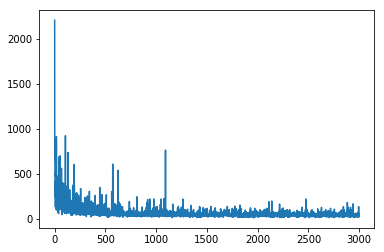

In [50]:
plt.figure()
plt.plot(losses_4)
plt.show()

## Training with embedding size = 4

In [51]:
epoch_range = 3000
batch_size = 150
learning_rate = 0.0001
seq_len = 3
embedding_size = 4

lstm_ae_5 = lstm_autoencoder(length, seq_len, embedding_size)
lstm_ae_5.apply(init_lstm_weights)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    lstm_ae_5.parameters(), lr=learning_rate, weight_decay=0.001)

enc, out, losses_5 = train_lstm(lstm_ae_5, electrode_data_train, criterion, optimizer, epoch_range, batch_size)

epoch [1/3000], loss:3171.03809, avg:3171.03809
epoch [2/3000], loss:903.21173, avg:2037.12488
epoch [3/3000], loss:315.66522, avg:1463.30505
epoch [4/3000], loss:517.10730, avg:1226.75562
epoch [5/3000], loss:90.92494, avg:999.58948
epoch [6/3000], loss:317.91229, avg:885.97656
epoch [7/3000], loss:204.83946, avg:788.67126
epoch [8/3000], loss:62.99705, avg:697.96198
epoch [9/3000], loss:244.46521, avg:647.57349
epoch [10/3000], loss:223.75648, avg:605.19177
epoch [11/3000], loss:138.23500, avg:301.91147
epoch [12/3000], loss:487.60056, avg:260.35037
epoch [13/3000], loss:198.43773, avg:248.62759
epoch [14/3000], loss:133.05986, avg:210.22287
epoch [15/3000], loss:211.25829, avg:222.25620
epoch [16/3000], loss:174.49753, avg:207.91472
epoch [17/3000], loss:199.82793, avg:207.41357
epoch [18/3000], loss:104.06536, avg:211.52039
epoch [19/3000], loss:347.56131, avg:221.83000
epoch [20/3000], loss:123.43529, avg:211.79788
epoch [21/3000], loss:75.86632, avg:205.56100
epoch [22/3000], los

epoch [175/3000], loss:98.70741, avg:202.08737
epoch [176/3000], loss:49.87487, avg:188.37381
epoch [177/3000], loss:77.18331, avg:177.84431
epoch [178/3000], loss:196.52373, avg:177.34567
epoch [179/3000], loss:49.67709, avg:175.89381
epoch [180/3000], loss:199.09993, avg:181.77266
epoch [181/3000], loss:140.80997, avg:182.98148
epoch [182/3000], loss:500.01212, avg:224.89853
epoch [183/3000], loss:47.28543, avg:186.91013
epoch [184/3000], loss:300.98868, avg:166.01625
epoch [185/3000], loss:151.12625, avg:171.25813
epoch [186/3000], loss:96.42748, avg:175.91339
epoch [187/3000], loss:90.53365, avg:177.24843
epoch [188/3000], loss:59.13034, avg:163.50909
epoch [189/3000], loss:40.07203, avg:162.54858
epoch [190/3000], loss:83.83257, avg:151.02185
epoch [191/3000], loss:49.07820, avg:141.84868
epoch [192/3000], loss:87.92827, avg:100.64028
epoch [193/3000], loss:229.32231, avg:118.84397
epoch [194/3000], loss:73.29359, avg:96.07447
epoch [195/3000], loss:81.47977, avg:89.10982
epoch [1

epoch [349/3000], loss:145.40979, avg:90.90033
epoch [350/3000], loss:180.06264, avg:103.60248
epoch [351/3000], loss:119.38211, avg:110.41267
epoch [352/3000], loss:144.09427, avg:112.17654
epoch [353/3000], loss:38.97746, avg:109.01146
epoch [354/3000], loss:23.73024, avg:101.38887
epoch [355/3000], loss:47.85575, avg:101.59303
epoch [356/3000], loss:50.86382, avg:92.84059
epoch [357/3000], loss:186.72406, avg:99.70500
epoch [358/3000], loss:45.52715, avg:98.26273
epoch [359/3000], loss:65.70633, avg:90.29238
epoch [360/3000], loss:213.24646, avg:93.61076
epoch [361/3000], loss:93.83309, avg:91.05586
epoch [362/3000], loss:108.18018, avg:87.46445
epoch [363/3000], loss:96.31494, avg:93.19820
epoch [364/3000], loss:51.71447, avg:95.99663
epoch [365/3000], loss:156.33577, avg:106.84463
epoch [366/3000], loss:156.35420, avg:117.39366
epoch [367/3000], loss:98.66402, avg:108.58766
epoch [368/3000], loss:56.69704, avg:109.70465
epoch [369/3000], loss:101.88037, avg:113.32204
epoch [370/30

epoch [526/3000], loss:47.21632, avg:64.64346
epoch [527/3000], loss:63.14619, avg:66.72645
epoch [528/3000], loss:99.50890, avg:70.22623
epoch [529/3000], loss:56.69121, avg:72.40438
epoch [530/3000], loss:102.84101, avg:70.35065
epoch [531/3000], loss:201.22406, avg:83.24641
epoch [532/3000], loss:103.08212, avg:86.50674
epoch [533/3000], loss:71.24038, avg:88.95263
epoch [534/3000], loss:51.26736, avg:86.21615
epoch [535/3000], loss:65.58865, avg:86.18062
epoch [536/3000], loss:50.50386, avg:86.50937
epoch [537/3000], loss:50.14281, avg:85.20903
epoch [538/3000], loss:43.93221, avg:79.65137
epoch [539/3000], loss:110.49264, avg:85.03150
epoch [540/3000], loss:68.21328, avg:81.56873
epoch [541/3000], loss:137.16415, avg:75.16274
epoch [542/3000], loss:104.41798, avg:75.29634
epoch [543/3000], loss:124.85741, avg:80.65804
epoch [544/3000], loss:89.95170, avg:84.52647
epoch [545/3000], loss:57.96627, avg:83.76424
epoch [546/3000], loss:63.21095, avg:85.03494
epoch [547/3000], loss:33.8

epoch [704/3000], loss:45.73836, avg:61.05581
epoch [705/3000], loss:98.48874, avg:63.83666
epoch [706/3000], loss:66.98806, avg:65.50638
epoch [707/3000], loss:45.45891, avg:61.49170
epoch [708/3000], loss:101.27840, avg:67.22234
epoch [709/3000], loss:60.53348, avg:67.96987
epoch [710/3000], loss:83.61506, avg:71.04465
epoch [711/3000], loss:56.21996, avg:72.92928
epoch [712/3000], loss:82.79223, avg:67.54171
epoch [713/3000], loss:45.87902, avg:68.69922
epoch [714/3000], loss:36.07296, avg:67.73268
epoch [715/3000], loss:104.19119, avg:68.30293
epoch [716/3000], loss:80.67239, avg:69.67136
epoch [717/3000], loss:422.98038, avg:107.42351
epoch [718/3000], loss:62.28957, avg:103.52462
epoch [719/3000], loss:60.72981, avg:103.54427
epoch [720/3000], loss:38.24003, avg:99.00675
epoch [721/3000], loss:37.04210, avg:97.08897
epoch [722/3000], loss:41.99284, avg:93.00903
epoch [723/3000], loss:60.54494, avg:94.47562
epoch [724/3000], loss:57.75272, avg:96.64360
epoch [725/3000], loss:78.70

epoch [881/3000], loss:44.09187, avg:67.78025
epoch [882/3000], loss:69.13622, avg:66.96387
epoch [883/3000], loss:69.58154, avg:66.13477
epoch [884/3000], loss:61.21415, avg:68.51006
epoch [885/3000], loss:35.43245, avg:67.00121
epoch [886/3000], loss:114.78185, avg:70.84317
epoch [887/3000], loss:66.88873, avg:72.18560
epoch [888/3000], loss:45.49653, avg:71.32930
epoch [889/3000], loss:50.31977, avg:64.85597
epoch [890/3000], loss:44.42092, avg:60.13640
epoch [891/3000], loss:63.98406, avg:62.12562
epoch [892/3000], loss:111.33128, avg:66.34513
epoch [893/3000], loss:76.46882, avg:67.03386
epoch [894/3000], loss:104.00910, avg:71.31335
epoch [895/3000], loss:62.00524, avg:73.97063
epoch [896/3000], loss:48.76373, avg:67.36882
epoch [897/3000], loss:42.47332, avg:64.92728
epoch [898/3000], loss:89.50603, avg:69.32823
epoch [899/3000], loss:63.63313, avg:70.65956
epoch [900/3000], loss:90.71003, avg:75.28847
epoch [901/3000], loss:105.46951, avg:79.43702
epoch [902/3000], loss:65.5126

epoch [1058/3000], loss:76.71331, avg:79.89177
epoch [1059/3000], loss:60.28735, avg:65.91872
epoch [1060/3000], loss:83.84930, avg:69.01855
epoch [1061/3000], loss:69.26547, avg:69.56670
epoch [1062/3000], loss:50.60295, avg:68.28484
epoch [1063/3000], loss:86.78072, avg:72.15908
epoch [1064/3000], loss:95.08476, avg:67.50373
epoch [1065/3000], loss:50.97346, avg:66.36625
epoch [1066/3000], loss:75.01864, avg:69.04124
epoch [1067/3000], loss:42.14712, avg:69.07230
epoch [1068/3000], loss:61.98436, avg:67.59941
epoch [1069/3000], loss:41.68130, avg:65.73881
epoch [1070/3000], loss:61.03253, avg:63.45713
epoch [1071/3000], loss:50.06082, avg:61.53667
epoch [1072/3000], loss:43.81204, avg:60.85757
epoch [1073/3000], loss:86.08510, avg:60.78801
epoch [1074/3000], loss:74.84286, avg:58.76382
epoch [1075/3000], loss:53.71971, avg:59.03845
epoch [1076/3000], loss:82.92989, avg:59.82957
epoch [1077/3000], loss:47.29549, avg:60.34440
epoch [1078/3000], loss:77.80791, avg:61.92677
epoch [1079/3

epoch [1232/3000], loss:132.27080, avg:89.00207
epoch [1233/3000], loss:59.49714, avg:89.60063
epoch [1234/3000], loss:30.91510, avg:70.83244
epoch [1235/3000], loss:59.90483, avg:71.76879
epoch [1236/3000], loss:46.20333, avg:72.54660
epoch [1237/3000], loss:27.13868, avg:67.23714
epoch [1238/3000], loss:94.94656, avg:71.60521
epoch [1239/3000], loss:61.62840, avg:70.92186
epoch [1240/3000], loss:100.32963, avg:72.41786
epoch [1241/3000], loss:64.83494, avg:67.76694
epoch [1242/3000], loss:164.09233, avg:70.94910
epoch [1243/3000], loss:101.42953, avg:75.14233
epoch [1244/3000], loss:48.89193, avg:76.94001
epoch [1245/3000], loss:69.88688, avg:77.93822
epoch [1246/3000], loss:70.28836, avg:80.34672
epoch [1247/3000], loss:53.41331, avg:82.97418
epoch [1248/3000], loss:40.56576, avg:77.53612
epoch [1249/3000], loss:94.25826, avg:80.79910
epoch [1250/3000], loss:109.73293, avg:81.73942
epoch [1251/3000], loss:45.10419, avg:79.76634
epoch [1252/3000], loss:25.81920, avg:65.93903
epoch [1

epoch [1406/3000], loss:134.27272, avg:66.38224
epoch [1407/3000], loss:80.30066, avg:65.68398
epoch [1408/3000], loss:51.12454, avg:64.11072
epoch [1409/3000], loss:75.87279, avg:67.73100
epoch [1410/3000], loss:183.76996, avg:81.81496
epoch [1411/3000], loss:66.78065, avg:82.56161
epoch [1412/3000], loss:49.01009, avg:81.13150
epoch [1413/3000], loss:53.06496, avg:80.19174
epoch [1414/3000], loss:46.13628, avg:80.73878
epoch [1415/3000], loss:37.87480, avg:77.82075
epoch [1416/3000], loss:91.68388, avg:73.56186
epoch [1417/3000], loss:57.57801, avg:71.28960
epoch [1418/3000], loss:61.17171, avg:72.29431
epoch [1419/3000], loss:57.29707, avg:70.43674
epoch [1420/3000], loss:78.98338, avg:59.95809
epoch [1421/3000], loss:70.53705, avg:60.33372
epoch [1422/3000], loss:114.67994, avg:66.90071
epoch [1423/3000], loss:80.16470, avg:69.61068
epoch [1424/3000], loss:65.21955, avg:71.51901
epoch [1425/3000], loss:46.71517, avg:72.40304
epoch [1426/3000], loss:120.24373, avg:75.25903
epoch [14

epoch [1580/3000], loss:72.32225, avg:87.09577
epoch [1581/3000], loss:85.01217, avg:89.32491
epoch [1582/3000], loss:60.69033, avg:91.13181
epoch [1583/3000], loss:56.39759, avg:88.63559
epoch [1584/3000], loss:63.17905, avg:90.09151
epoch [1585/3000], loss:179.60081, avg:97.38259
epoch [1586/3000], loss:45.73567, avg:91.91776
epoch [1587/3000], loss:115.40418, avg:87.96333
epoch [1588/3000], loss:150.37866, avg:89.99834
epoch [1589/3000], loss:135.88133, avg:96.46021
epoch [1590/3000], loss:57.62549, avg:94.99052
epoch [1591/3000], loss:95.31074, avg:96.02039
epoch [1592/3000], loss:29.54265, avg:92.90562
epoch [1593/3000], loss:92.39140, avg:96.50500
epoch [1594/3000], loss:130.22414, avg:103.20951
epoch [1595/3000], loss:37.91004, avg:89.04043
epoch [1596/3000], loss:57.03204, avg:90.17007
epoch [1597/3000], loss:69.29978, avg:85.55963
epoch [1598/3000], loss:85.98166, avg:79.11993
epoch [1599/3000], loss:102.78385, avg:75.81019
epoch [1600/3000], loss:43.30005, avg:74.37764
epoch 

epoch [1753/3000], loss:180.26668, avg:80.68369
epoch [1754/3000], loss:61.91547, avg:81.09525
epoch [1755/3000], loss:108.97469, avg:79.64705
epoch [1756/3000], loss:23.92861, avg:74.78043
epoch [1757/3000], loss:21.53684, avg:70.20677
epoch [1758/3000], loss:49.07161, avg:67.70495
epoch [1759/3000], loss:23.29448, avg:62.10633
epoch [1760/3000], loss:50.82319, avg:61.46715
epoch [1761/3000], loss:73.70697, avg:62.36299
epoch [1762/3000], loss:64.12099, avg:65.76396
epoch [1763/3000], loss:63.94820, avg:54.13210
epoch [1764/3000], loss:52.60156, avg:53.20072
epoch [1765/3000], loss:72.34454, avg:49.53770
epoch [1766/3000], loss:102.31859, avg:57.37670
epoch [1767/3000], loss:85.50698, avg:63.77371
epoch [1768/3000], loss:78.32649, avg:66.69920
epoch [1769/3000], loss:47.80522, avg:69.15028
epoch [1770/3000], loss:95.98915, avg:73.66686
epoch [1771/3000], loss:44.88214, avg:70.78439
epoch [1772/3000], loss:57.61431, avg:70.13372
epoch [1773/3000], loss:46.64132, avg:68.40303
epoch [177

epoch [1927/3000], loss:38.87022, avg:72.69215
epoch [1928/3000], loss:55.03397, avg:70.93423
epoch [1929/3000], loss:71.56517, avg:67.67960
epoch [1930/3000], loss:53.01169, avg:66.22298
epoch [1931/3000], loss:116.27610, avg:70.88509
epoch [1932/3000], loss:54.79123, avg:71.32943
epoch [1933/3000], loss:100.71410, avg:73.22267
epoch [1934/3000], loss:59.15826, avg:72.44991
epoch [1935/3000], loss:61.61610, avg:69.24731
epoch [1936/3000], loss:70.44362, avg:68.14804
epoch [1937/3000], loss:61.59134, avg:70.42015
epoch [1938/3000], loss:75.54080, avg:72.47084
epoch [1939/3000], loss:96.00090, avg:74.91441
epoch [1940/3000], loss:37.79803, avg:73.39304
epoch [1941/3000], loss:117.33452, avg:73.49889
epoch [1942/3000], loss:52.52036, avg:73.27180
epoch [1943/3000], loss:89.95407, avg:72.19580
epoch [1944/3000], loss:80.35047, avg:74.31503
epoch [1945/3000], loss:97.37086, avg:77.89050
epoch [1946/3000], loss:36.02406, avg:74.44853
epoch [1947/3000], loss:71.86526, avg:75.47593
epoch [194

epoch [2101/3000], loss:63.72773, avg:95.81047
epoch [2102/3000], loss:58.82488, avg:93.48120
epoch [2103/3000], loss:82.77325, avg:90.26482
epoch [2104/3000], loss:127.91331, avg:96.14654
epoch [2105/3000], loss:47.57501, avg:97.02620
epoch [2106/3000], loss:40.96141, avg:95.34411
epoch [2107/3000], loss:45.79383, avg:95.57239
epoch [2108/3000], loss:46.19561, avg:90.85248
epoch [2109/3000], loss:57.61761, avg:61.26301
epoch [2110/3000], loss:112.98591, avg:68.43685
epoch [2111/3000], loss:128.45695, avg:74.90977
epoch [2112/3000], loss:47.86113, avg:73.81340
epoch [2113/3000], loss:24.69296, avg:68.00537
epoch [2114/3000], loss:69.49584, avg:62.16362
epoch [2115/3000], loss:56.11767, avg:63.01789
epoch [2116/3000], loss:44.62603, avg:63.38436
epoch [2117/3000], loss:64.73183, avg:65.27815
epoch [2118/3000], loss:112.28840, avg:71.88744
epoch [2119/3000], loss:52.30587, avg:71.35625
epoch [2120/3000], loss:46.55207, avg:64.71288
epoch [2121/3000], loss:46.69227, avg:56.53641
epoch [21

epoch [2275/3000], loss:34.16454, avg:64.24929
epoch [2276/3000], loss:49.95824, avg:63.31951
epoch [2277/3000], loss:58.28984, avg:61.36371
epoch [2278/3000], loss:72.12888, avg:63.24556
epoch [2279/3000], loss:59.89523, avg:61.76350
epoch [2280/3000], loss:67.86837, avg:58.64889
epoch [2281/3000], loss:57.91354, avg:56.27756
epoch [2282/3000], loss:56.18130, avg:57.41216
epoch [2283/3000], loss:103.96236, avg:63.40609
epoch [2284/3000], loss:48.91805, avg:60.92803
epoch [2285/3000], loss:34.84437, avg:60.99601
epoch [2286/3000], loss:55.81269, avg:61.58146
epoch [2287/3000], loss:64.36185, avg:62.18866
epoch [2288/3000], loss:159.93166, avg:70.96893
epoch [2289/3000], loss:150.39023, avg:80.01845
epoch [2290/3000], loss:100.72545, avg:83.30415
epoch [2291/3000], loss:154.53650, avg:92.96645
epoch [2292/3000], loss:28.46258, avg:90.19457
epoch [2293/3000], loss:50.13270, avg:84.81160
epoch [2294/3000], loss:67.05472, avg:86.62527
epoch [2295/3000], loss:88.52602, avg:91.99343
epoch [2

epoch [2449/3000], loss:85.13109, avg:77.44868
epoch [2450/3000], loss:139.28088, avg:84.51736
epoch [2451/3000], loss:55.12564, avg:85.48380
epoch [2452/3000], loss:290.43808, avg:104.73801
epoch [2453/3000], loss:53.66876, avg:102.21998
epoch [2454/3000], loss:53.08537, avg:101.82638
epoch [2455/3000], loss:51.80436, avg:98.25190
epoch [2456/3000], loss:69.75245, avg:98.01859
epoch [2457/3000], loss:60.91681, avg:94.94726
epoch [2458/3000], loss:67.92810, avg:92.71316
epoch [2459/3000], loss:359.75168, avg:120.17522
epoch [2460/3000], loss:51.88060, avg:111.43520
epoch [2461/3000], loss:73.74493, avg:113.29710
epoch [2462/3000], loss:55.61827, avg:89.81514
epoch [2463/3000], loss:40.04974, avg:88.45323
epoch [2464/3000], loss:83.40758, avg:91.48546
epoch [2465/3000], loss:52.04851, avg:91.50987
epoch [2466/3000], loss:77.15883, avg:92.25050
epoch [2467/3000], loss:35.36005, avg:89.69483
epoch [2468/3000], loss:70.04617, avg:89.90664
epoch [2469/3000], loss:117.49229, avg:65.68070
epo

epoch [2623/3000], loss:49.15414, avg:58.94413
epoch [2624/3000], loss:70.62344, avg:56.83100
epoch [2625/3000], loss:177.39513, avg:71.37529
epoch [2626/3000], loss:112.23429, avg:74.02490
epoch [2627/3000], loss:34.79017, avg:70.13779
epoch [2628/3000], loss:82.58237, avg:74.76802
epoch [2629/3000], loss:64.78931, avg:77.32113
epoch [2630/3000], loss:90.75664, avg:82.99660
epoch [2631/3000], loss:114.17187, avg:89.27345
epoch [2632/3000], loss:119.86832, avg:91.63657
epoch [2633/3000], loss:99.69119, avg:96.69027
epoch [2634/3000], loss:70.06274, avg:96.63420
epoch [2635/3000], loss:78.17262, avg:86.71195
epoch [2636/3000], loss:123.93183, avg:87.88171
epoch [2637/3000], loss:27.35355, avg:87.13804
epoch [2638/3000], loss:57.01283, avg:84.58109
epoch [2639/3000], loss:70.30645, avg:85.13280
epoch [2640/3000], loss:115.02471, avg:87.55961
epoch [2641/3000], loss:63.72245, avg:82.51466
epoch [2642/3000], loss:46.87791, avg:75.21563
epoch [2643/3000], loss:56.96390, avg:70.94290
epoch [

epoch [2797/3000], loss:122.69418, avg:89.77267
epoch [2798/3000], loss:51.43374, avg:89.38579
epoch [2799/3000], loss:69.68744, avg:91.76521
epoch [2800/3000], loss:56.33130, avg:73.71679
epoch [2801/3000], loss:97.48836, avg:77.30840
epoch [2802/3000], loss:82.22198, avg:78.70973
epoch [2803/3000], loss:43.15246, avg:72.54872
epoch [2804/3000], loss:67.21816, avg:70.50860
epoch [2805/3000], loss:40.56135, avg:69.96679
epoch [2806/3000], loss:75.13492, avg:70.59238
epoch [2807/3000], loss:50.24600, avg:63.34757
epoch [2808/3000], loss:46.71391, avg:62.87559
epoch [2809/3000], loss:45.51875, avg:60.45872
epoch [2810/3000], loss:82.28721, avg:63.05431
epoch [2811/3000], loss:56.30321, avg:58.93580
epoch [2812/3000], loss:67.10429, avg:57.42402
epoch [2813/3000], loss:73.17119, avg:60.42590
epoch [2814/3000], loss:36.16466, avg:57.32055
epoch [2815/3000], loss:68.98595, avg:60.16301
epoch [2816/3000], loss:49.35236, avg:57.58475
epoch [2817/3000], loss:44.49986, avg:57.01014
epoch [2818/

epoch [2971/3000], loss:69.40192, avg:49.70138
epoch [2972/3000], loss:68.26659, avg:53.39291
epoch [2973/3000], loss:72.92044, avg:55.94062
epoch [2974/3000], loss:53.40699, avg:57.48655
epoch [2975/3000], loss:62.77066, avg:58.59069
epoch [2976/3000], loss:50.59796, avg:59.05103
epoch [2977/3000], loss:91.39510, avg:63.03983
epoch [2978/3000], loss:96.90021, avg:63.15340
epoch [2979/3000], loss:71.88126, avg:65.91931
epoch [2980/3000], loss:42.61053, avg:68.01517
epoch [2981/3000], loss:59.88026, avg:67.06300
epoch [2982/3000], loss:40.98684, avg:64.33502
epoch [2983/3000], loss:115.30359, avg:68.57334
epoch [2984/3000], loss:68.70837, avg:70.10348
epoch [2985/3000], loss:42.04349, avg:68.03076
epoch [2986/3000], loss:55.54656, avg:68.52562
epoch [2987/3000], loss:61.63820, avg:65.54993
epoch [2988/3000], loss:51.54263, avg:61.01417
epoch [2989/3000], loss:55.69286, avg:59.39533
epoch [2990/3000], loss:78.89541, avg:63.02382
epoch [2991/3000], loss:38.62837, avg:60.89863
epoch [2992/

In [52]:
torch.save(lstm_ae_5, 'models/visapy/lstm_4.pt') #Saving the autoencoder model

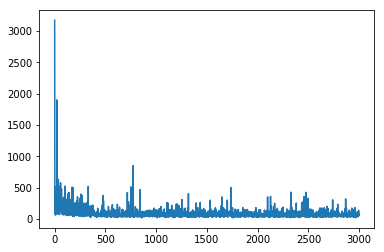

In [53]:
plt.figure()
plt.plot(losses_5)
plt.show()

## Training with embedding size = 2

In [35]:
epoch_range = 3000
batch_size = 150
learning_rate = 0.0001
seq_len = 3
embedding_size = 2

lstm_ae_6 = lstm_autoencoder(length, seq_len, embedding_size)
lstm_ae_6.apply(init_lstm_weights)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    lstm_ae_6.parameters(), lr=learning_rate, weight_decay=0.001)

enc, out, losses_6 = train_lstm(lstm_ae_6, electrode_data_train, criterion, optimizer, epoch_range, batch_size)

epoch [1/3000], loss:2161.73657, avg:2161.73657
epoch [2/3000], loss:1043.93433, avg:1602.83545
epoch [3/3000], loss:1037.17480, avg:1414.28186
epoch [4/3000], loss:366.60321, avg:1152.36218
epoch [5/3000], loss:406.81699, avg:1003.25311
epoch [6/3000], loss:241.61717, avg:876.31378
epoch [7/3000], loss:236.53973, avg:784.91748
epoch [8/3000], loss:523.66559, avg:752.26099
epoch [9/3000], loss:839.71478, avg:761.97809
epoch [10/3000], loss:183.62430, avg:704.14270
epoch [11/3000], loss:124.54180, avg:500.42328
epoch [12/3000], loss:180.37807, avg:414.06763
epoch [13/3000], loss:103.60429, avg:320.71060
epoch [14/3000], loss:494.20038, avg:333.47031
epoch [15/3000], loss:417.69476, avg:334.55811
epoch [16/3000], loss:160.95491, avg:326.49188
epoch [17/3000], loss:690.01935, avg:371.83978
epoch [18/3000], loss:326.16025, avg:352.08926
epoch [19/3000], loss:555.53729, avg:323.67157
epoch [20/3000], loss:174.28931, avg:322.73804
epoch [21/3000], loss:233.42816, avg:333.62668
epoch [22/3000

epoch [175/3000], loss:123.65617, avg:212.50870
epoch [176/3000], loss:325.37170, avg:217.58618
epoch [177/3000], loss:287.27502, avg:223.60210
epoch [178/3000], loss:159.47267, avg:225.47098
epoch [179/3000], loss:93.63821, avg:200.56448
epoch [180/3000], loss:232.39432, avg:199.50983
epoch [181/3000], loss:1119.36230, avg:298.84784
epoch [182/3000], loss:185.68230, avg:288.07651
epoch [183/3000], loss:156.28749, avg:279.42999
epoch [184/3000], loss:169.16574, avg:285.23062
epoch [185/3000], loss:84.15355, avg:281.28033
epoch [186/3000], loss:202.54988, avg:268.99814
epoch [187/3000], loss:195.74767, avg:259.84540
epoch [188/3000], loss:70.67275, avg:250.96541
epoch [189/3000], loss:448.45407, avg:286.44699
epoch [190/3000], loss:360.22226, avg:299.22980
epoch [191/3000], loss:104.07603, avg:197.70119
epoch [192/3000], loss:82.89869, avg:187.42282
epoch [193/3000], loss:201.54195, avg:191.94827
epoch [194/3000], loss:218.99120, avg:196.93082
epoch [195/3000], loss:96.96545, avg:198.21

epoch [347/3000], loss:131.07593, avg:118.75313
epoch [348/3000], loss:56.12777, avg:118.42206
epoch [349/3000], loss:138.99510, avg:121.98959
epoch [350/3000], loss:162.54805, avg:123.70074
epoch [351/3000], loss:84.28039, avg:124.33488
epoch [352/3000], loss:57.65733, avg:93.05801
epoch [353/3000], loss:61.51196, avg:93.37203
epoch [354/3000], loss:162.78059, avg:105.59882
epoch [355/3000], loss:55.12975, avg:98.17570
epoch [356/3000], loss:88.66221, avg:99.87691
epoch [357/3000], loss:99.53186, avg:96.72250
epoch [358/3000], loss:115.44425, avg:102.65415
epoch [359/3000], loss:79.99920, avg:96.75456
epoch [360/3000], loss:62.59510, avg:86.75926
epoch [361/3000], loss:117.73901, avg:90.10513
epoch [362/3000], loss:1046.62097, avg:189.00150
epoch [363/3000], loss:121.09200, avg:194.95950
epoch [364/3000], loss:189.89323, avg:197.67076
epoch [365/3000], loss:181.93080, avg:210.35086
epoch [366/3000], loss:75.96237, avg:209.08089
epoch [367/3000], loss:896.91650, avg:288.81934
epoch [36

epoch [520/3000], loss:93.25227, avg:150.61583
epoch [521/3000], loss:72.57511, avg:138.94814
epoch [522/3000], loss:109.10487, avg:126.23260
epoch [523/3000], loss:89.48764, avg:122.46445
epoch [524/3000], loss:109.59687, avg:120.92975
epoch [525/3000], loss:79.78042, avg:111.13773
epoch [526/3000], loss:78.97374, avg:101.07728
epoch [527/3000], loss:54.44172, avg:92.09169
epoch [528/3000], loss:165.48575, avg:97.08240
epoch [529/3000], loss:233.61479, avg:108.63131
epoch [530/3000], loss:564.60913, avg:155.76700
epoch [531/3000], loss:107.90847, avg:159.30034
epoch [532/3000], loss:129.99310, avg:161.38916
epoch [533/3000], loss:153.26607, avg:167.76701
epoch [534/3000], loss:67.54589, avg:163.56192
epoch [535/3000], loss:103.22531, avg:165.90640
epoch [536/3000], loss:160.69559, avg:174.07858
epoch [537/3000], loss:76.00751, avg:176.23518
epoch [538/3000], loss:232.79198, avg:182.96579
epoch [539/3000], loss:271.46271, avg:186.75056
epoch [540/3000], loss:128.13609, avg:143.10326
ep

epoch [693/3000], loss:43.50579, avg:124.05530
epoch [694/3000], loss:70.83294, avg:123.11749
epoch [695/3000], loss:307.70001, avg:142.55518
epoch [696/3000], loss:49.84005, avg:136.63834
epoch [697/3000], loss:115.32895, avg:123.48331
epoch [698/3000], loss:64.94903, avg:123.04407
epoch [699/3000], loss:108.02719, avg:128.04501
epoch [700/3000], loss:173.97609, avg:128.18344
epoch [701/3000], loss:93.54992, avg:124.79781
epoch [702/3000], loss:58.77612, avg:108.64861
epoch [703/3000], loss:126.93674, avg:116.99171
epoch [704/3000], loss:159.22083, avg:125.83049
epoch [705/3000], loss:51.62236, avg:100.22272
epoch [706/3000], loss:127.81754, avg:108.02048
epoch [707/3000], loss:251.62199, avg:121.64978
epoch [708/3000], loss:183.72794, avg:133.52768
epoch [709/3000], loss:162.90172, avg:139.01512
epoch [710/3000], loss:98.66001, avg:131.48352
epoch [711/3000], loss:362.51273, avg:158.37979
epoch [712/3000], loss:64.67342, avg:158.96953
epoch [713/3000], loss:144.88542, avg:160.76439
e

epoch [866/3000], loss:79.30742, avg:123.77419
epoch [867/3000], loss:118.14224, avg:119.82328
epoch [868/3000], loss:221.59930, avg:132.49307
epoch [869/3000], loss:157.78494, avg:135.63937
epoch [870/3000], loss:118.72463, avg:136.58749
epoch [871/3000], loss:155.39395, avg:139.24011
epoch [872/3000], loss:102.57986, avg:140.84099
epoch [873/3000], loss:37.13032, avg:134.34531
epoch [874/3000], loss:267.02618, avg:151.98239
epoch [875/3000], loss:132.19209, avg:138.98808
epoch [876/3000], loss:222.89806, avg:153.34715
epoch [877/3000], loss:152.08182, avg:156.74112
epoch [878/3000], loss:227.42314, avg:157.32349
epoch [879/3000], loss:91.14418, avg:150.65941
epoch [880/3000], loss:150.14629, avg:153.80157
epoch [881/3000], loss:78.08063, avg:146.07024
epoch [882/3000], loss:145.90211, avg:150.40247
epoch [883/3000], loss:83.30244, avg:155.01970
epoch [884/3000], loss:71.20470, avg:135.43755
epoch [885/3000], loss:71.84494, avg:129.40285
epoch [886/3000], loss:93.45483, avg:116.45851


epoch [1039/3000], loss:131.43933, avg:134.38205
epoch [1040/3000], loss:660.34906, avg:188.86963
epoch [1041/3000], loss:120.42203, avg:190.51210
epoch [1042/3000], loss:149.58322, avg:194.30524
epoch [1043/3000], loss:183.47812, avg:201.00058
epoch [1044/3000], loss:43.82153, avg:185.18735
epoch [1045/3000], loss:148.05554, avg:175.10788
epoch [1046/3000], loss:144.64285, avg:176.76112
epoch [1047/3000], loss:131.66699, avg:181.46690
epoch [1048/3000], loss:71.21124, avg:178.46700
epoch [1049/3000], loss:121.82951, avg:177.50601
epoch [1050/3000], loss:188.93179, avg:130.36429
epoch [1051/3000], loss:69.83123, avg:125.30520
epoch [1052/3000], loss:72.34274, avg:117.58115
epoch [1053/3000], loss:282.16440, avg:127.44979
epoch [1054/3000], loss:213.71442, avg:144.43906
epoch [1055/3000], loss:164.54884, avg:146.08841
epoch [1056/3000], loss:100.86648, avg:141.71077
epoch [1057/3000], loss:152.42642, avg:143.78671
epoch [1058/3000], loss:90.99869, avg:145.76544
epoch [1059/3000], loss:9

epoch [1208/3000], loss:183.82265, avg:149.38307
epoch [1209/3000], loss:46.43476, avg:146.51520
epoch [1210/3000], loss:339.15433, avg:159.16309
epoch [1211/3000], loss:147.35210, avg:157.72668
epoch [1212/3000], loss:152.78650, avg:162.39420
epoch [1213/3000], loss:312.77518, avg:183.18869
epoch [1214/3000], loss:141.20070, avg:177.72304
epoch [1215/3000], loss:70.87050, avg:179.27910
epoch [1216/3000], loss:61.55345, avg:172.26956
epoch [1217/3000], loss:105.26486, avg:156.12151
epoch [1218/3000], loss:103.17905, avg:148.05714
epoch [1219/3000], loss:132.84373, avg:156.69804
epoch [1220/3000], loss:59.89639, avg:128.77225
epoch [1221/3000], loss:265.90448, avg:140.62749
epoch [1222/3000], loss:57.68670, avg:131.11749
epoch [1223/3000], loss:113.67998, avg:111.20798
epoch [1224/3000], loss:94.54809, avg:106.54272
epoch [1225/3000], loss:102.48071, avg:109.70375
epoch [1226/3000], loss:76.81736, avg:111.23014
epoch [1227/3000], loss:518.09442, avg:152.51309
epoch [1228/3000], loss:52.

epoch [1378/3000], loss:148.09486, avg:147.01802
epoch [1379/3000], loss:43.40182, avg:141.91541
epoch [1380/3000], loss:206.63095, avg:140.53886
epoch [1381/3000], loss:55.28119, avg:124.99758
epoch [1382/3000], loss:127.76646, avg:120.62101
epoch [1383/3000], loss:111.42145, avg:120.57436
epoch [1384/3000], loss:50.73452, avg:117.03861
epoch [1385/3000], loss:53.35354, avg:89.78997
epoch [1386/3000], loss:65.74889, avg:91.81954
epoch [1387/3000], loss:52.11765, avg:91.45513
epoch [1388/3000], loss:73.08047, avg:83.95369
epoch [1389/3000], loss:131.51170, avg:92.76468
epoch [1390/3000], loss:49.47123, avg:77.04871
epoch [1391/3000], loss:573.93652, avg:128.91425
epoch [1392/3000], loss:176.01141, avg:133.73874
epoch [1393/3000], loss:107.13434, avg:133.31001
epoch [1394/3000], loss:128.57596, avg:141.09416
epoch [1395/3000], loss:111.84798, avg:146.94362
epoch [1396/3000], loss:85.40137, avg:148.90884
epoch [1397/3000], loss:40.33990, avg:147.73108
epoch [1398/3000], loss:127.31929, a

epoch [1548/3000], loss:161.32692, avg:130.69679
epoch [1549/3000], loss:192.23221, avg:143.61588
epoch [1550/3000], loss:77.01000, avg:140.91743
epoch [1551/3000], loss:49.72261, avg:124.91650
epoch [1552/3000], loss:69.71593, avg:99.97783
epoch [1553/3000], loss:80.01257, avg:98.44618
epoch [1554/3000], loss:129.98853, avg:99.76639
epoch [1555/3000], loss:76.05806, avg:97.30283
epoch [1556/3000], loss:104.33602, avg:101.11617
epoch [1557/3000], loss:147.38466, avg:108.77875
epoch [1558/3000], loss:156.94229, avg:108.34029
epoch [1559/3000], loss:303.57718, avg:119.47478
epoch [1560/3000], loss:68.89677, avg:118.66345
epoch [1561/3000], loss:101.84954, avg:123.87614
epoch [1562/3000], loss:213.87878, avg:138.29243
epoch [1563/3000], loss:75.92657, avg:137.88383
epoch [1564/3000], loss:131.77861, avg:138.06284
epoch [1565/3000], loss:157.09909, avg:146.16695
epoch [1566/3000], loss:89.86434, avg:144.71979
epoch [1567/3000], loss:103.10310, avg:140.29164
epoch [1568/3000], loss:55.71690

epoch [1717/3000], loss:54.99352, avg:93.89413
epoch [1718/3000], loss:76.31044, avg:90.32822
epoch [1719/3000], loss:188.23938, avg:99.78886
epoch [1720/3000], loss:97.77484, avg:103.52165
epoch [1721/3000], loss:71.95340, avg:99.58382
epoch [1722/3000], loss:109.45359, avg:96.09198
epoch [1723/3000], loss:60.05204, avg:89.73587
epoch [1724/3000], loss:78.03608, avg:87.09336
epoch [1725/3000], loss:375.70563, avg:116.65320
epoch [1726/3000], loss:114.91760, avg:122.74365
epoch [1727/3000], loss:54.83528, avg:122.72783
epoch [1728/3000], loss:123.60757, avg:127.45754
epoch [1729/3000], loss:55.82880, avg:114.21648
epoch [1730/3000], loss:85.38034, avg:112.97703
epoch [1731/3000], loss:214.40605, avg:127.22229
epoch [1732/3000], loss:118.03674, avg:128.08060
epoch [1733/3000], loss:69.93246, avg:129.06865
epoch [1734/3000], loss:98.24577, avg:131.08961
epoch [1735/3000], loss:84.16197, avg:101.93526
epoch [1736/3000], loss:53.89058, avg:95.83256
epoch [1737/3000], loss:67.77107, avg:97.

epoch [1887/3000], loss:151.03006, avg:110.51610
epoch [1888/3000], loss:80.41376, avg:112.75181
epoch [1889/3000], loss:155.96257, avg:115.91510
epoch [1890/3000], loss:89.94652, avg:114.21471
epoch [1891/3000], loss:52.53767, avg:109.21201
epoch [1892/3000], loss:192.81187, avg:117.58181
epoch [1893/3000], loss:173.71692, avg:127.90633
epoch [1894/3000], loss:79.83318, avg:124.37054
epoch [1895/3000], loss:88.09707, avg:118.64199
epoch [1896/3000], loss:107.73388, avg:117.20835
epoch [1897/3000], loss:493.53961, avg:151.45930
epoch [1898/3000], loss:230.82698, avg:166.50064
epoch [1899/3000], loss:39.20864, avg:154.82524
epoch [1900/3000], loss:121.42767, avg:157.97336
epoch [1901/3000], loss:158.35744, avg:168.55533
epoch [1902/3000], loss:84.81028, avg:157.75516
epoch [1903/3000], loss:189.45877, avg:159.32935
epoch [1904/3000], loss:62.43232, avg:157.58926
epoch [1905/3000], loss:45.03616, avg:153.28317
epoch [1906/3000], loss:122.42698, avg:154.75249
epoch [1907/3000], loss:275.6

epoch [2056/3000], loss:75.26686, avg:131.23067
epoch [2057/3000], loss:160.01028, avg:134.34166
epoch [2058/3000], loss:73.07150, avg:119.77164
epoch [2059/3000], loss:134.81195, avg:120.12663
epoch [2060/3000], loss:121.62518, avg:120.82259
epoch [2061/3000], loss:57.60934, avg:111.30756
epoch [2062/3000], loss:147.36806, avg:119.03711
epoch [2063/3000], loss:112.30315, avg:118.98313
epoch [2064/3000], loss:154.32698, avg:119.25832
epoch [2065/3000], loss:126.97273, avg:116.33661
epoch [2066/3000], loss:121.29399, avg:120.93931
epoch [2067/3000], loss:668.14160, avg:171.75244
epoch [2068/3000], loss:96.06709, avg:174.05202
epoch [2069/3000], loss:286.42529, avg:189.21335
epoch [2070/3000], loss:61.39566, avg:183.19040
epoch [2071/3000], loss:62.29002, avg:183.65846
epoch [2072/3000], loss:81.06915, avg:177.02856
epoch [2073/3000], loss:99.82516, avg:175.78079
epoch [2074/3000], loss:58.41801, avg:166.18987
epoch [2075/3000], loss:104.65073, avg:163.95767
epoch [2076/3000], loss:96.80

epoch [2226/3000], loss:65.69920, avg:112.33325
epoch [2227/3000], loss:63.60997, avg:109.42783
epoch [2228/3000], loss:120.41742, avg:110.94356
epoch [2229/3000], loss:69.47747, avg:109.65025
epoch [2230/3000], loss:87.34256, avg:112.34021
epoch [2231/3000], loss:127.94381, avg:107.44733
epoch [2232/3000], loss:61.73676, avg:100.34420
epoch [2233/3000], loss:99.55507, avg:94.71991
epoch [2234/3000], loss:202.60735, avg:94.74711
epoch [2235/3000], loss:129.35825, avg:102.77478
epoch [2236/3000], loss:86.00562, avg:104.80544
epoch [2237/3000], loss:504.16779, avg:148.86121
epoch [2238/3000], loss:152.89412, avg:152.10887
epoch [2239/3000], loss:148.40025, avg:160.00117
epoch [2240/3000], loss:102.51161, avg:161.51808
epoch [2241/3000], loss:82.68461, avg:156.99216
epoch [2242/3000], loss:245.57654, avg:175.37613
epoch [2243/3000], loss:48.97900, avg:170.31851
epoch [2244/3000], loss:184.59195, avg:168.51697
epoch [2245/3000], loss:212.49780, avg:176.83092
epoch [2246/3000], loss:42.3499

epoch [2395/3000], loss:73.48278, avg:101.91808
epoch [2396/3000], loss:132.45694, avg:105.32642
epoch [2397/3000], loss:82.65022, avg:104.26941
epoch [2398/3000], loss:53.69340, avg:98.69059
epoch [2399/3000], loss:146.78445, avg:96.14127
epoch [2400/3000], loss:115.12354, avg:94.55857
epoch [2401/3000], loss:75.66069, avg:92.17738
epoch [2402/3000], loss:177.87352, avg:102.87992
epoch [2403/3000], loss:277.13422, avg:118.08673
epoch [2404/3000], loss:70.88552, avg:120.57452
epoch [2405/3000], loss:115.77631, avg:124.80388
epoch [2406/3000], loss:45.58064, avg:116.11625
epoch [2407/3000], loss:112.61599, avg:119.11283
epoch [2408/3000], loss:93.15006, avg:123.05849
epoch [2409/3000], loss:63.01957, avg:114.68199
epoch [2410/3000], loss:92.42312, avg:112.41196
epoch [2411/3000], loss:75.73367, avg:112.41927
epoch [2412/3000], loss:166.41376, avg:111.27329
epoch [2413/3000], loss:180.92993, avg:101.65285
epoch [2414/3000], loss:52.36416, avg:99.80071
epoch [2415/3000], loss:70.75706, av

epoch [2565/3000], loss:74.04268, avg:125.25670
epoch [2566/3000], loss:64.43800, avg:120.28550
epoch [2567/3000], loss:172.46191, avg:122.58705
epoch [2568/3000], loss:76.01806, avg:123.73733
epoch [2569/3000], loss:65.46450, avg:125.33573
epoch [2570/3000], loss:71.39914, avg:115.73219
epoch [2571/3000], loss:45.86388, avg:100.74251
epoch [2572/3000], loss:114.93495, avg:101.38271
epoch [2573/3000], loss:106.20985, avg:93.63184
epoch [2574/3000], loss:196.09789, avg:98.69309
epoch [2575/3000], loss:179.88438, avg:109.27726
epoch [2576/3000], loss:64.71915, avg:109.30537
epoch [2577/3000], loss:67.65768, avg:98.82495
epoch [2578/3000], loss:184.38312, avg:109.66145
epoch [2579/3000], loss:106.17379, avg:113.73240
epoch [2580/3000], loss:197.84299, avg:126.37677
epoch [2581/3000], loss:200.04204, avg:141.79459
epoch [2582/3000], loss:47.18898, avg:135.01999
epoch [2583/3000], loss:190.67258, avg:143.46625
epoch [2584/3000], loss:212.74521, avg:145.13101
epoch [2585/3000], loss:97.35712

epoch [2734/3000], loss:155.54823, avg:146.03804
epoch [2735/3000], loss:86.98504, avg:150.74240
epoch [2736/3000], loss:143.32047, avg:131.46620
epoch [2737/3000], loss:106.80571, avg:135.48982
epoch [2738/3000], loss:96.13458, avg:133.67693
epoch [2739/3000], loss:464.66006, avg:166.86322
epoch [2740/3000], loss:59.61225, avg:162.06541
epoch [2741/3000], loss:101.79070, avg:153.16824
epoch [2742/3000], loss:70.12119, avg:144.32852
epoch [2743/3000], loss:76.34577, avg:136.13242
epoch [2744/3000], loss:134.80717, avg:134.05830
epoch [2745/3000], loss:103.52212, avg:135.71201
epoch [2746/3000], loss:126.17905, avg:133.99786
epoch [2747/3000], loss:62.80158, avg:129.59746
epoch [2748/3000], loss:275.56210, avg:147.54021
epoch [2749/3000], loss:305.07758, avg:131.58195
epoch [2750/3000], loss:1256.48767, avg:251.26949
epoch [2751/3000], loss:124.88351, avg:253.57878
epoch [2752/3000], loss:159.32033, avg:262.49872
epoch [2753/3000], loss:107.06135, avg:265.57025
epoch [2754/3000], loss:2

epoch [2903/3000], loss:124.61823, avg:142.56540
epoch [2904/3000], loss:224.15543, avg:143.36633
epoch [2905/3000], loss:125.10101, avg:139.72195
epoch [2906/3000], loss:124.38881, avg:116.72955
epoch [2907/3000], loss:118.50031, avg:120.16316
epoch [2908/3000], loss:57.69392, avg:105.50487
epoch [2909/3000], loss:73.50536, avg:104.02795
epoch [2910/3000], loss:128.48540, avg:108.69118
epoch [2911/3000], loss:67.70962, avg:110.07725
epoch [2912/3000], loss:38.96249, avg:108.31206
epoch [2913/3000], loss:61.35921, avg:101.98615
epoch [2914/3000], loss:66.09940, avg:86.18054
epoch [2915/3000], loss:105.29147, avg:84.19959
epoch [2916/3000], loss:71.90618, avg:78.95133
epoch [2917/3000], loss:299.06433, avg:97.00774
epoch [2918/3000], loss:61.49089, avg:97.38744
epoch [2919/3000], loss:116.87358, avg:101.72426
epoch [2920/3000], loss:135.96756, avg:102.47247
epoch [2921/3000], loss:156.52571, avg:111.35409
epoch [2922/3000], loss:89.47663, avg:116.40550
epoch [2923/3000], loss:223.98970,

In [36]:
torch.save(lstm_ae_6, 'models/visapy/lstm_2.pt') #Saving the autoencoder model

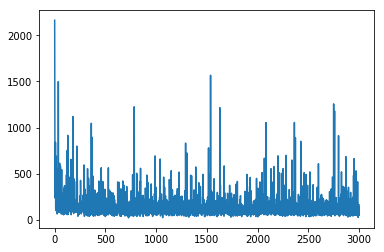

In [37]:
plt.figure()
plt.plot(losses_6)
plt.show()

## Plotting autoencoder Reconstructions

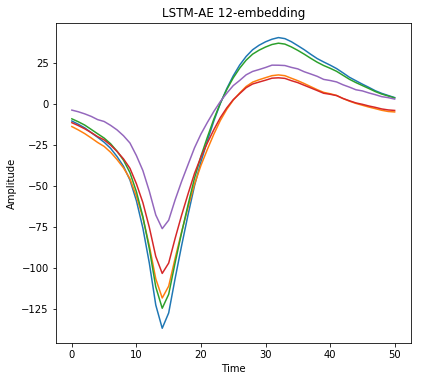

In [34]:
plt.figure(figsize=(14,20))

n = [1, 30, 45, 50, 65]
#n = [11, 290, 3490, 1098, 2707, 9, 871]


for i in n:
    data = electrode_data_test[i, :]
    data = torch.from_numpy(data).float()
    
    enc, o_1 = lstm_ae_1.forward(data)
    o_1 = (o_1.data).cpu().numpy()
    #print(np.sum(np.subtract(electrode_data_test[i, :], o_1)))
#     enc, o_2 = lstm_ae_2.forward(data)
#     o_2 = (o_2.data).cpu().numpy()
#     #print(np.sum(np.subtract(electrode_data_test[i, :], o_2)))
#     enc, o_3 = lstm_ae_3.forward(data)
#     o_3 = (o_3.data).cpu().numpy()
#     #print(np.sum(np.subtract(electrode_data_test[i, :], o_3)))
#     enc, o_4 = lstm_ae_4.forward(data)
#     o_4 = (o_4.data).cpu().numpy()
#     #print(np.sum(np.subtract(electrode_data_test[i, :], o_4)))
#     enc, o_5 = lstm_ae_5.forward(data)
#     o_5 = (o_5.data).cpu().numpy()
#     #print(np.sum(np.subtract(electrode_data_test[i, :], o_5)))
#     enc, o_6 = lstm_ae_6.forward(data)
#     o_6 = (o_6.data).cpu().numpy()
#     #print(np.sum(np.subtract(electrode_data_test[i, :], o_6)))
#     #print('-----------------')
    plt.subplot(321)
    plt.plot(o_1)
    plt.title('LSTM-AE 12-embedding')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
#     plt.subplot(322)
#     plt.plot(o_2)
#     plt.title('LSTM-AE 10-embedding')
#     plt.xlabel('Time')
#     plt.ylabel('Amplitude')
#     plt.subplot(323)
#     plt.plot(o_3)
#     plt.title('LSTM-AE 8-embedding')
#     plt.xlabel('Time')
#     plt.ylabel('Amplitude')
#     plt.subplot(324)
#     plt.plot(o_4)
#     plt.title('LSTM-AE 6-embedding')
#     plt.xlabel('Time')
#     plt.ylabel('Amplitude')
#     plt.subplot(325)
#     plt.plot(o_5)
#     plt.title('LSTM-AE 4-embedding')
#     plt.xlabel('Time')
#     plt.ylabel('Amplitude')
#     plt.subplot(326)
#     plt.plot(o_6)
#     plt.title('LSTM-AE 2-embedding')
#     plt.xlabel('Time')
#     plt.ylabel('Amplitude')
plt.show()

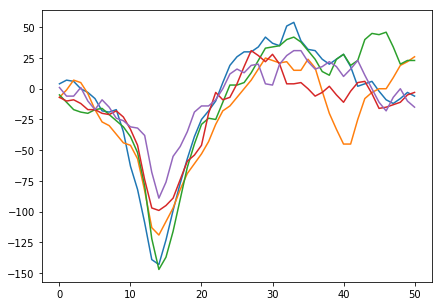

In [58]:
plt.figure(figsize=(7,5))

n = [1, 30, 45, 50, 65]
#n = [11, 290, 3490, 1098, 2707, 9, 871]
for i in n:
    plt.plot(electrode_data_test[i, :])
plt.show()

# ---------------- LOAD MODELS TO USE -------------------

In [ ]:
# train_lim = int(0.8*electrode_data.shape[0])
# electrode_data_train = electrode_data[:train_lim, :]
# electrode_data_test = electrode_data[train_lim:, :]

# print("Training Datasize:", electrode_data_train.shape)
# print("Test Datasize:", electrode_data_test.shape)

### Loading the models

In [23]:
# Make sure to execute autoencoder model code before executing this

#lstm_ae_1 = torch.load('models/visapy/lstm_12.pt')
lstm_ae_2 = torch.load('models/visapy/lstm_10.pt')
lstm_ae_3 = torch.load('models/visapy/lstm_8.pt')
lstm_ae_4 = torch.load('models/visapy/lstm_6.pt')
lstm_ae_5 = torch.load('models/visapy/lstm_4.pt')
lstm_ae_6 = torch.load('models/visapy/lstm_2.pt')